In [1]:
import socket
if socket.gethostname() == 'dlm':
  %env CUDA_DEVICE_ORDER=PCI_BUS_ID
  %env CUDA_VISIBLE_DEVICES=1

In [2]:
import os
import sys
import re
import collections
import functools
import requests, zipfile, io
import pickle
import copy

import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import sklearn.decomposition
import sklearn.metrics
import networkx

import torch
import torch.nn as nn

lib_path = 'I:/code'
if not os.path.exists(lib_path):
  lib_path = '/media/6T/.tianle/.lib'
if not os.path.exists(lib_path):
  lib_path = '/projects/academic/azhang/tianlema/lib'
if os.path.exists(lib_path) and lib_path not in sys.path:
  sys.path.append(lib_path)
  
from dl.models.basic_models import *
from dl.utils.visualization.visualization import *
from dl.utils.outlier import *
from dl.utils.train import *
from autoencoder.autoencoder import *
from dl.utils.utils import get_overlap_samples, filter_clinical_dict, get_target_variable
from dl.utils.utils import get_shuffled_data, target_to_numpy

%load_ext autoreload
%autoreload 2


use_gpu = True
if use_gpu and torch.cuda.is_available():
  device = torch.device('cuda')
  print('Using GPU:)')
else:
  device = torch.device('cpu')
  print('Using CPU:(')

Using GPU:)


In [3]:
model_type = 'nn'
dense = False
residual = False
hidden_dim = [100, 100]
train_portion = 0.7
val_portion = 0.1
test_portion = 0.2
num_sets = 10
num_folds = 10
num_train_types = -1
num_val_types = -1
num_test_types = -1
cv_type = 'instance-shuffle'
sel_set_idx = 4
sel_disease_types = 'all'
min_num_samples_per_type_cls = [100, 0]
predefined_sample_set_file = 'auto-search'
target_variable = 'PFI'
target_variable_type = 'discrete'
target_variable_range = [0, 1]
data_type = ['gene', 'mirna', 'rppa', 'methy']
additional_vars = ['age_at_initial_pathologic_diagnosis', 'gender', 'ajcc_pathologic_tumor_stage']
additional_var_types = ['continuous', 'discrete', 'discrete']
additional_var_ranges = [[0, 100], ['MALE', 'FEMALE'], ['I/II NOS', 'IS', 'Stage 0', 'Stage I', 'Stage IA', 'Stage IB', 'Stage II', 'Stage IIA', 'Stage IIB', 'Stage IIC', 'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC', 'Stage IV', 'Stage IVA', 'Stage IVB', 'Stage IVC', 'Stage X']]
normal_transform_feature = True
randomize_labels = False
lr = 0.0005
weight_decay = 0.0001
num_epochs = 500
reduce_every = 500
show_results_in_notebook = True

## Prepare data

In [4]:
result_folder = 'results'
data_split_idx_folder = f'{result_folder}/data_split_idx'
project_folder = '../../pan-can-atlas' # on dlm or ccr
print_stats = True
if not os.path.exists(project_folder):
  project_folder = 'F:/TCGA/Pan-Cancer-Atlas' # on my own desktop
filepath = f'{project_folder}/data/processed/combined2.pkl'
with open(filepath, 'rb') as f:
  data = pickle.load(f)
  patient_clinical = data['patient_clinical']
  feature_mat_dict = data['feature_mat_dict']
  feature_interaction_mat_dict = data['feature_interaction_mat_dict']
  feature_id_dict = data['feature_id_dict']
  aliquot_id_dict = data['aliquot_id_dict']
#   sel_patient_ids = data['sample_id_sel']
#   sample_idx_sel_dict = data['sample_idx_sel_dict']
#   for k, v in sample_idx_sel_dict.items():
#     assert [i[:12] for i in aliquot_id_dict[k][v]] == sel_patient_ids

if print_stats:
  for k, v in feature_mat_dict.items():
    print(f'feature_mat: {k}, max={v.max():.3f}, min={v.min():.3f}, '
          f'mean={v.mean():.3f}, {np.mean(v>0):.3f}')  
  for k, v in feature_interaction_mat_dict.items():
    print(f'feature_interaction_mat: {k}, max={v.max():.3f}, min={v.min():.3f}, '
          f'mean={v.mean():.3f}, {np.mean(v>0):.3f}') 
  for k, v in feature_id_dict.items():
    print(k, v.shape, v[0])
  for k, v in aliquot_id_dict.items():
    print(k, v.shape, v[0])

feature_mat: rppa, max=14.141, min=-7.869, mean=0.095, 0.516
feature_mat: mirna, max=11.813, min=0.000, mean=3.743, 1.000
feature_mat: gene, max=16.311, min=0.000, mean=8.412, 1.000
feature_mat: methy, max=1.000, min=0.000, mean=0.553, 1.000
feature_interaction_mat: rppa, max=1.000, min=0.000, mean=0.198, 0.277
feature_interaction_mat: mirna, max=1.000, min=0.010, mean=0.492, 1.000
feature_interaction_mat: gene, max=1.000, min=0.000, mean=0.050, 0.146
feature_interaction_mat: methy, max=1.000, min=0.000, mean=0.057, 0.127
rppa (189,) X1433EPSILON
mirna (662,) hsa-let-7a-2-3p
gene (4942,) A1BG
methy (4753,) cg00005847
rppa (7480,) TCGA-OR-A5J2-01A-21-A39K-20
mirna (9554,) TCGA-C4-A0F6-01A-11R-A10V-13
gene (9702,) TCGA-OR-A5J1-01A-11R-A29S-07
methy (10268,) TCGA-02-0001-01C-01D-0186-05


In [5]:
# select samples with required clinical variables
clinical_dict = filter_clinical_dict(target_variable, target_variable_type=target_variable_type, 
                                     target_variable_range=target_variable_range, 
                                     clinical_dict=patient_clinical)
if len(additional_vars) > 0:
  clinical_dict = filter_clinical_dict(additional_vars, target_variable_type=additional_var_types, 
                                       target_variable_range=additional_var_ranges, 
                                       clinical_dict=clinical_dict)

# select samples with feature matrix of given type(s)
if isinstance(data_type, str):
  sample_list = {s[:12] for s in aliquot_id_dict[data_type]}
  data_type_str = data_type
elif isinstance(data_type, (list, tuple)):
  sample_list = get_overlap_samples([aliquot_id_dict[dtype] for dtype in data_type], 
                                    common_list=None, start=0, end=12, return_common_list=True)
  data_type_str = '-'.join(sorted(data_type))
else:
  raise ValueError(f'data_type must be str or list/tuple, but is {type(data_type)}')
sample_list = set(sample_list).intersection(clinical_dict)

# select samples with given disease types
sel_disease_type_str = sel_disease_types # will be overwritten if it is a list
if isinstance(sel_disease_types, (list, tuple)):
  sample_list = [s for s in sample_list if clinical_dict[s]['type'] in sel_disease_types]
  sel_disease_type_str = '-'.join(sorted(sel_disease_types))
elif isinstance(sel_disease_types, str) and sel_disease_types!='all':
  sample_list = [s for s in sample_list if clinical_dict[s]['type'] == sel_disease_types]
else:
  assert sel_disease_types == 'all'
 
# For classification tasks with given min_num_samples_per_type_cls,
# only keep disease types that have a minimal number of samples per type and per class
# Reflection: it might be better to use collections.defaultdict(list) to store samples in each type
type_cnt = collections.Counter([clinical_dict[s]['type'] for s in sample_list])
if sum(min_num_samples_per_type_cls)>0 and (target_variable_type=='discrete' 
                                            or target_variable_type[0]=='discrete'):
  # the number of samples in each disease type >= min_num_samples_per_type_cls[0]
  type_cnt = {k: v for k, v in type_cnt.items() if v >= min_num_samples_per_type_cls[0]}
  disease_type_cnt = {}
  for k in type_cnt:
    # collections.Counter can accept generator
    cls_cnt = collections.Counter(clinical_dict[s][target_variable] 
                                  if isinstance(target_variable, str) 
                                  else clinical_dict[s][target_variable[0]] 
                                  for s in sample_list if clinical_dict[s]['type']==k)
    if all([v >= min_num_samples_per_type_cls[1] for v in cls_cnt.values()]):
      # the number of samples in each class >= min_num_samples_per_type_cls[1]
      disease_type_cnt[k] = dict(cls_cnt)
      print(k, disease_type_cnt[k])
  sample_list = [s for s in sample_list if clinical_dict[s]['type'] in disease_type_cnt]
sel_patient_ids = sorted(sample_list)
print(f'Selected {len(sel_patient_ids)} patients from {len(disease_type_cnt)} disease_types')

KIRP {1.0: 45, 0.0: 154}
LUSC {0.0: 197, 1.0: 98}
BRCA {0.0: 735, 1.0: 104}
KIRC {0.0: 293, 1.0: 150}
THCA {0.0: 327, 1.0: 41}
BLCA {1.0: 147, 0.0: 189}
PAAD {1.0: 71, 0.0: 42}
COAD {0.0: 235, 1.0: 88}
LUAD {0.0: 200, 1.0: 135}
STAD {1.0: 100, 0.0: 203}
READ {0.0: 87, 1.0: 23}
LIHC {0.0: 83, 1.0: 80}
ESCA {1.0: 48, 0.0: 69}
HNSC {1.0: 87, 0.0: 112}
Selected 4143 patients from 14 disease_types


### Split data into training, validation, and test sets

In [6]:
predefined_sample_set_filename = (target_variable if isinstance(target_variable,str) 
                                else '-'.join(target_variable))
predefined_sample_set_filename += f'_{cv_type}'
if len(additional_vars) > 0:
  predefined_sample_set_filename += f"_{'-'.join(sorted(additional_vars))}"

predefined_sample_set_filename += (f"_{data_type_str}_{sel_disease_type_str}_"
                                   f"{'-'.join(map(str, min_num_samples_per_type_cls))}")
predefined_sample_set_filename += f"_{'-'.join(map(str, [train_portion, val_portion, test_portion]))}"
if cv_type == 'group-shuffle' and num_train_types > 0:
  predefined_sample_set_filename += f"_{'-'.join(map(str, [num_train_types, num_val_types, num_test_types]))}"
predefined_sample_set_filename += f'_{num_sets}sets'
res_file = f"{predefined_sample_set_filename}_{sel_set_idx}_{'-'.join(map(str, hidden_dim))}_{model_type}.pkl"
predefined_sample_set_filename += '.pkl'
# This will be overwritten if predefined_sample_set_file == 'auto-search' or filepath, and the file exists
predefined_sample_sets = [get_shuffled_data(sel_patient_ids, clinical_dict, cv_type=cv_type, 
                  instance_portions=[train_portion, val_portion, test_portion], 
                  group_sizes=[num_train_types, num_val_types, num_test_types],
                  group_variable_name='type', seed=None, verbose=False) for i in range(num_sets)]
if predefined_sample_set_file == 'auto-search':
  if os.path.exists(f'{data_split_idx_folder}/{predefined_sample_set_filename}'):
    with open(f'{data_split_idx_folder}/{predefined_sample_set_filename}', 'rb') as f:
      print(f'Read predefined_sample_set_file: '
            f'{data_split_idx_folder}/{predefined_sample_set_filename}')
      tmp = pickle.load(f)
      # overwrite calculated predefined_sample_sets
      predefined_sample_sets = tmp['predefined_sample_sets']    
elif isinstance(predefined_sample_set_file, str): # but not 'auto-search'; assume it's a file name
  if os.path.exists(predefined_sample_set_file):
    with open(f'{data_split_idx_folder}/{predefined_sample_set_file}', 'rb') as f:
      print(f'Read predefined_sample_set_file: {data_split_idx_folder}/{predefined_sample_set_file}')
      tmp = pickle.load(f)
      predefined_sample_sets = tmp['predefined_sample_sets']
  else:
    raise ValueError(f'predefined_sample_set_file: {data_split_idx_folder}/{predefined_sample_set_file} does not exist!')

if (not os.path.exists(f'{data_split_idx_folder}/{predefined_sample_set_filename}') 
    and predefined_sample_set_file == 'auto-search') or predefined_sample_set_file is True:
  with open(f'{data_split_idx_folder}/{predefined_sample_set_filename}', 'wb') as f:
      print(f'Write predefined_sample_set_file: {data_split_idx_folder}/{predefined_sample_set_filename}')
      pickle.dump({'predefined_sample_sets': predefined_sample_sets}, f)
     
sel_patient_ids, idx_splits = predefined_sample_sets[sel_set_idx]
train_idx, val_idx, test_idx = idx_splits

Read predefined_sample_set_file: results/data_split_idx/PFI_instance-shuffle_age_at_initial_pathologic_diagnosis-ajcc_pathologic_tumor_stage-gender_gene-methy-mirna-rppa_all_100-0_0.7-0.1-0.2_10sets.pkl


In [7]:
if isinstance(data_type, str):
  sample_lists = [aliquot_id_dict[data_type]]
else:
  assert isinstance(data_type, (list, tuple))
  sample_lists = [aliquot_id_dict[dtype] for dtype in data_type]
idx_lists = get_overlap_samples(sample_lists=sample_lists, common_list=sel_patient_ids, 
                    start=0, end=12, return_common_list=False)
sample_idx_sel_dict = {}
if isinstance(data_type, str):
  sample_idx_sel_dict = {data_type: idx_lists[0]}
else:
  sample_idx_sel_dict = {dtype: idx_list for dtype, idx_list in zip(data_type, idx_lists)}

In [8]:
if isinstance(data_type, str):
  print(f'Only use one data type: {data_type}')
  num_data_types = 1
  mat = feature_mat_dict[data_type][sample_idx_sel_dict[data_type]]
  # Data preprocessing: make each row have mean 0 and sd 1.
  x = (mat - mat.mean(axis=1, keepdims=True)) / mat.std(axis=1, keepdims=True)
  interaction_mat = feature_interaction_mat_dict[data_type]
  interaction_mat = torch.from_numpy(interaction_mat).float().to(device)
  # Normalize these interaction mat
  interaction_mat = interaction_mat / interaction_mat.norm()
else:
  mat = []
  interaction_mats = []
  in_dims = []
  num_data_types = len(data_type)
  # do not handle the special case of [data_type] to avoid too much code complexity
  assert num_data_types > 1 
  for dtype in data_type: # multiple data types
    m = feature_mat_dict[dtype][sample_idx_sel_dict[dtype]]
    #When there are multiple data types, make sure each type is normalized to have mean 0 and std 1
    m = (m - m.mean(axis=1, keepdims=True)) / m.std(axis=1, keepdims=True)
    mat.append(m)
    in_dims.append(m.shape[1])
    # For neural network model graph laplacian regularizer
    interaction_mat = feature_interaction_mat_dict[dtype]
    interaction_mat = torch.from_numpy(interaction_mat).float().to(device)
    # Normalize these interaction mat
    interaction_mat = interaction_mat / interaction_mat.norm()
    interaction_mats.append(interaction_mat)
    print(f'{dtype}: {m.shape}; '
          f'interaction_mat: mean={interaction_mat.mean().item():2f}, '
          f'std={interaction_mat.std().item():2f}, {interaction_mat.shape[0]}')
  # Later interaction_mat will be passed to Loss_feature_interaction
  interaction_mat = interaction_mats
  mat = np.concatenate(mat, axis=1)
  # For machine learing methods that use concatenated features without knowing underlying views,
  # it might be good to make each row have mean 0 and sd 1.
  x = (mat - mat.mean(axis=1, keepdims=True)) / mat.std(axis=1, keepdims=True)

if normal_transform_feature:
  X = x
else:
  X = mat

gene: (4143, 4942); interaction_mat: mean=0.000057, std=0.000194, 4942
mirna: (4143, 662); interaction_mat: mean=0.001408, std=0.000547, 662
rppa: (4143, 189); interaction_mat: mean=0.002668, std=0.004569, 189
methy: (4143, 4753); interaction_mat: mean=0.000069, std=0.000199, 4753


In [9]:
y_targets = get_target_variable(target_variable, clinical_dict, sel_patient_ids)
y_true = target_to_numpy(y_targets, target_variable_type, target_variable_range)
if len(additional_vars) > 0:
  additional_variables = get_target_variable(additional_vars, clinical_dict, sel_patient_ids)
  # to do handle additional variables such as age and gender

Changed class labels for the model: {0.0: 0, 1.0: 1}


### To do: handle multiple inputs, multiple targets

In [10]:
# sklearn classifiers also accept torch.Tensor
X = torch.tensor(X).float().to(device)
y_true = torch.tensor(y_true).long().to(device)
num_cls = len(torch.unique(y_true))

x_train, y_train = X[train_idx], y_true[train_idx]
x_val, y_val = X[val_idx], y_true[val_idx]
x_test, y_test = X[test_idx], y_true[test_idx]
print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape)

label_prob_train = get_label_prob(y_train, verbose=False)
label_probs = [label_prob_train]
if len(y_val)>0:
  label_prob_val = get_label_prob(y_val, verbose=False)
  assert len(label_prob_train) == len(label_prob_val)
  label_probs.append(label_prob_val)
if len(y_test)>0:
  label_prob_test = get_label_prob(y_test, verbose=False)
  assert len(label_prob_train) == len(label_prob_test)
  label_probs.append(label_prob_test)
if isinstance(label_probs, torch.Tensor):
  print('label distribution:\n', torch.stack(label_probs, dim=1))
else:
  print('label distribution:\n', np.stack(label_probs, axis=1))

torch.Size([2900, 10546]) torch.Size([414, 10546]) torch.Size([829, 10546]) torch.Size([2900]) torch.Size([414]) torch.Size([829])
label distribution:
 [[0.7058621  0.71014494 0.70566946]
 [0.29413795 0.28985506 0.2943305 ]]


### Optionally randomize true class labels

In [11]:
if randomize_labels:
  print('Randomize class labels!')
  y_train = torch.multinomial(label_prob_train, len(y_train), replacement=True)
  if len(y_val) > 0:
    y_val = torch.multinomial(label_prob_val, len(y_val), replacement=True)
  if len(y_test) > 0:
    y_test = torch.multinomial(label_prob_test, len(y_test), replacement=True)

## Neural network models

In [12]:
# loss_fn_cls = torch.nn.CrossEntropyLoss(weight=torch.tensor([0.3, 0.6], device=device))
loss_fn_cls = torch.nn.CrossEntropyLoss()
loss_fn_reg = torch.nn.MSELoss()
loss_fns = [loss_fn_cls, loss_fn_reg]
# For multiple data types, there are multiple interaction mats
feat_interact_loss_type = 'graph_laplacian'
if num_data_types > 1:
  weight_path = ['decoders', range(num_data_types), 'weight']  
else:
  weight_path = ['decoder', 'weight']
loss_feat_interact = Loss_feature_interaction(interaction_mat=interaction_mat, 
                                              loss_type=feat_interact_loss_type, 
                                              weight_path=weight_path, 
                                              normalize=True)
other_loss_fns = [loss_feat_interact]
if num_data_types > 1:
  view_sim_loss_type = 'hub'
  explicit_target = True
  cal_target='mean-feature'
  # In this set of experiments, the encoders for all views will have the same hidden_dim
  loss_view_sim = Loss_view_similarity(sections=hidden_dim[-1], loss_type=view_sim_loss_type, 
    explicit_target=explicit_target, cal_target=cal_target, target=None)
  loss_fns.append(loss_view_sim)

In [13]:
model_names = []
split_names = ['train', 'val', 'test']
metric_names = ['acc', 'precision', 'recall', 'f1_score', 'adjusted_mutual_info', 'auc', 
                'average_precision']
metric_all = []
confusion_mat_all = []
loss_his_all = []
acc_his_all = []

In [14]:
def get_result(model, best_model, best_val_acc, best_epoch, x_train, y_train, x_val, y_val, 
               x_test, y_test, batch_size, multi_heads, show_results_in_notebook=True, 
               loss_idx=0, acc_idx=0):
  if len(x_val) > 0:
    print(f'Best model on validation set: best_val_acc={best_val_acc:.2f}, epoch={best_epoch}')
    metric = eval_classification_multi_splits(best_model, xs=[x_train, x_val, x_test], 
      ys=[y_train, y_val, y_test], batch_size=batch_size, multi_heads=multi_heads)

  if show_results_in_notebook:
    print('\nModel after the last training epoch:')
    eval_classification_multi_splits(model, xs=[x_train, x_val, x_test], 
                                     ys=[y_train, y_val, y_test], batch_size=batch_size, 
                                     multi_heads=multi_heads, return_result=False)

    plot_history_multi_splits([loss_train_his, loss_val_his, loss_test_his], title='Loss', 
                              idx=loss_idx)
    plot_history_multi_splits([acc_train_his, acc_val_his, acc_test_his], title='Acc', idx=acc_idx)
    # scatter plot
    plot_data_multi_splits(best_model, [x_train, x_val, x_test], [y_train, y_val, y_test], 
                           num_heads=2 if multi_heads else 1, 
                           titles=['Training', 'Validation', 'Test'], batch_size=batch_size)
    return metric

# Plain deep learning model

In [15]:
batch_size = 1000
print_every = 100
eval_every = 1

In [16]:
in_dim = x_train.shape[1]
print('Plain deep learning model')
model_names.append('NN')
model = DenseLinear(in_dim, hidden_dim+[num_cls], dense=dense, residual=residual).to(device)
multi_heads = False

loss_train_his = []
loss_val_his = []
loss_test_his = []
acc_train_his = []
acc_val_his = []
acc_test_his = []
best_model = model
best_val_acc = 0
best_epoch = 0

Plain deep learning model


In [17]:
best_model, best_val_acc, best_epoch = train_single_loss(model, x_train, y_train, 
    x_val, y_val, x_test, y_test, loss_fn=loss_fn_cls, lr=lr, weight_decay=weight_decay, 
    amsgrad=True, batch_size=batch_size, num_epochs=num_epochs, 
    reduce_every=reduce_every, eval_every=eval_every, print_every=print_every, verbose=False, 
    loss_train_his=loss_train_his, loss_val_his=loss_val_his, loss_test_his=loss_test_his, 
    acc_train_his=acc_train_his, acc_val_his=acc_val_his, acc_test_his=acc_test_his, 
    return_best_val=True)

Epoch0 Train: loss=8.90e-01, acc=0.71
Epoch0 Test: loss=5.94e-01, acc=0.71
epoch 0, best_val_acc=0.71, train_acc=0.71
Epoch0 Test: loss=6.01e-01, acc=0.71
epoch 6, best_val_acc=0.71, train_acc=0.71
epoch 7, best_val_acc=0.73, train_acc=0.71
epoch 8, best_val_acc=0.73, train_acc=0.73
epoch 14, best_val_acc=0.74, train_acc=0.75
Epoch100 Train: loss=8.25e-02, acc=0.99
Epoch100 Test: loss=8.84e-01, acc=0.68
Epoch100 Test: loss=9.01e-01, acc=0.68
Epoch200 Train: loss=9.42e-03, acc=1.00
Epoch200 Test: loss=1.40e+00, acc=0.69
Epoch200 Test: loss=1.46e+00, acc=0.68
Epoch300 Train: loss=1.18e-03, acc=1.00
Epoch300 Test: loss=1.99e+00, acc=0.68
Epoch300 Test: loss=2.10e+00, acc=0.67
Epoch400 Train: loss=3.43e-04, acc=1.00
Epoch400 Test: loss=2.26e+00, acc=0.68
Epoch400 Test: loss=2.40e+00, acc=0.67


Best model on validation set: best_val_acc=0.74, epoch=14
Train
acc=0.754, precision=0.747, recall=0.754, fl=0.712, adj_MI=0.079, auc=0.770, ap=0.595, confusion_mat=
[[1958   89]
 [ 625  228]]
report              precision    recall  f1-score   support

          0       0.76      0.96      0.85      2047
          1       0.72      0.27      0.39       853

avg / total       0.75      0.75      0.71      2900

Validataion
acc=0.737, precision=0.713, recall=0.737, fl=0.692, adj_MI=0.047, auc=0.705, ap=0.505, confusion_mat=
[[277  17]
 [ 92  28]]
report              precision    recall  f1-score   support

          0       0.75      0.94      0.84       294
          1       0.62      0.23      0.34       120

avg / total       0.71      0.74      0.69       414

Test
acc=0.720, precision=0.688, recall=0.720, fl=0.676, adj_MI=0.034, auc=0.715, ap=0.498, confusion_mat=
[[542  43]
 [189  55]]
report              precision    recall  f1-score   support

          0       0.74      0.93   

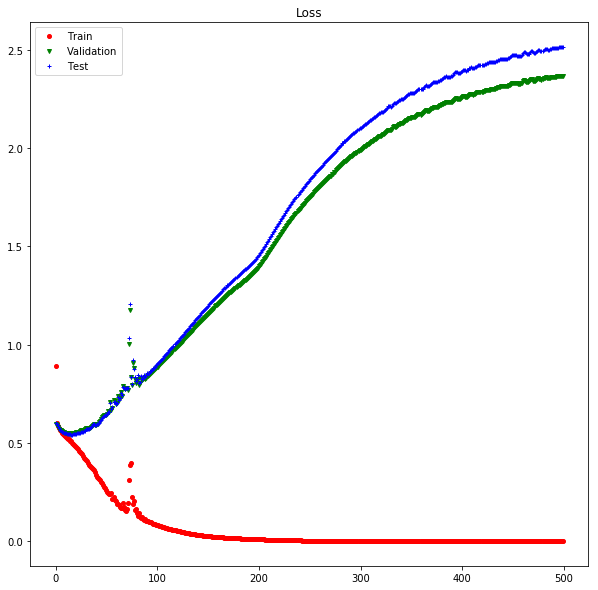

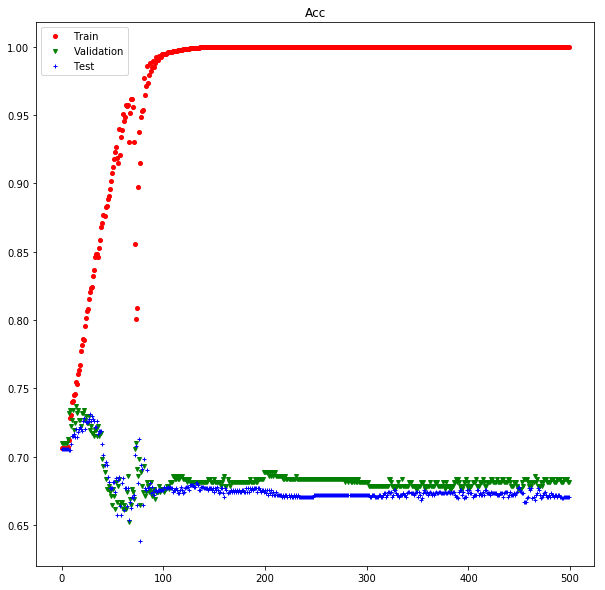

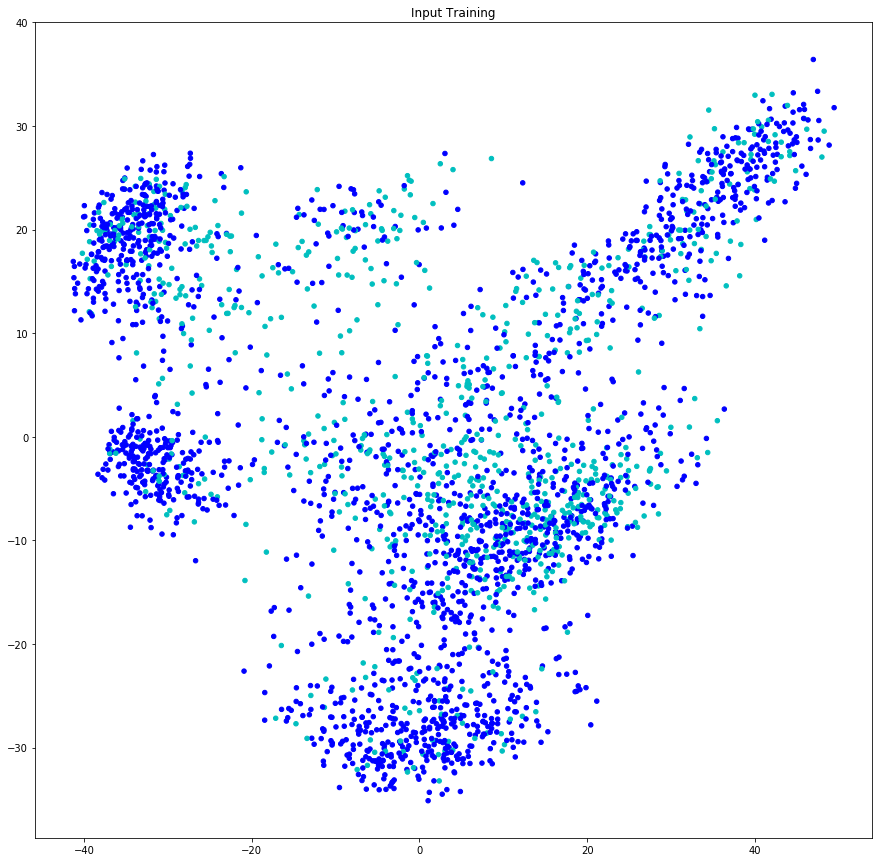

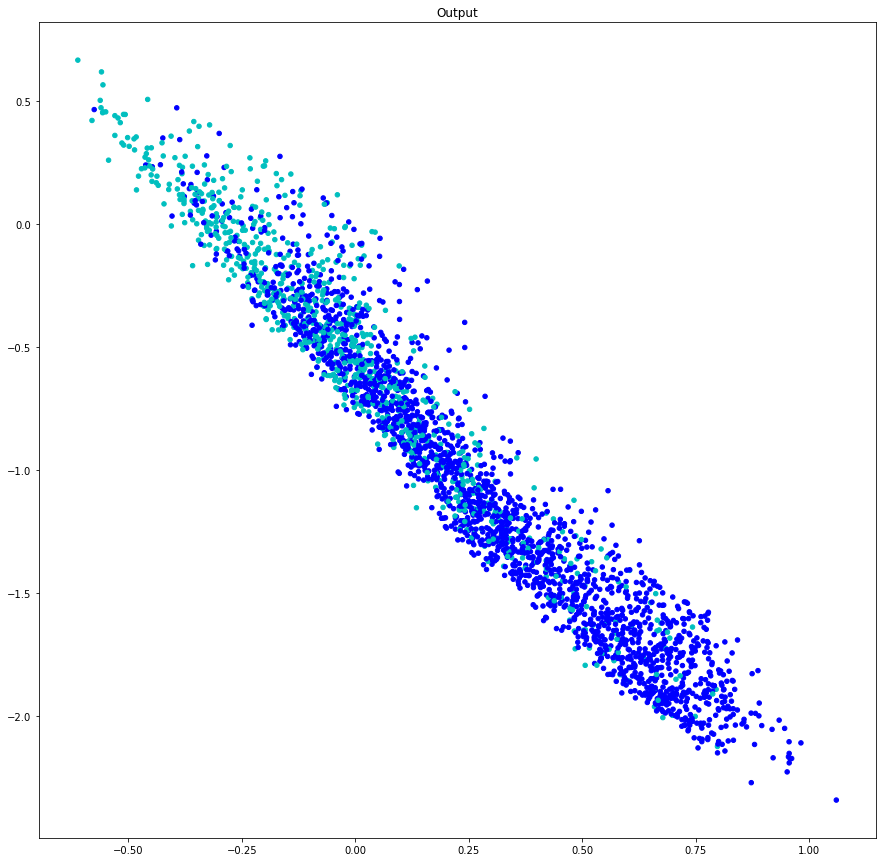

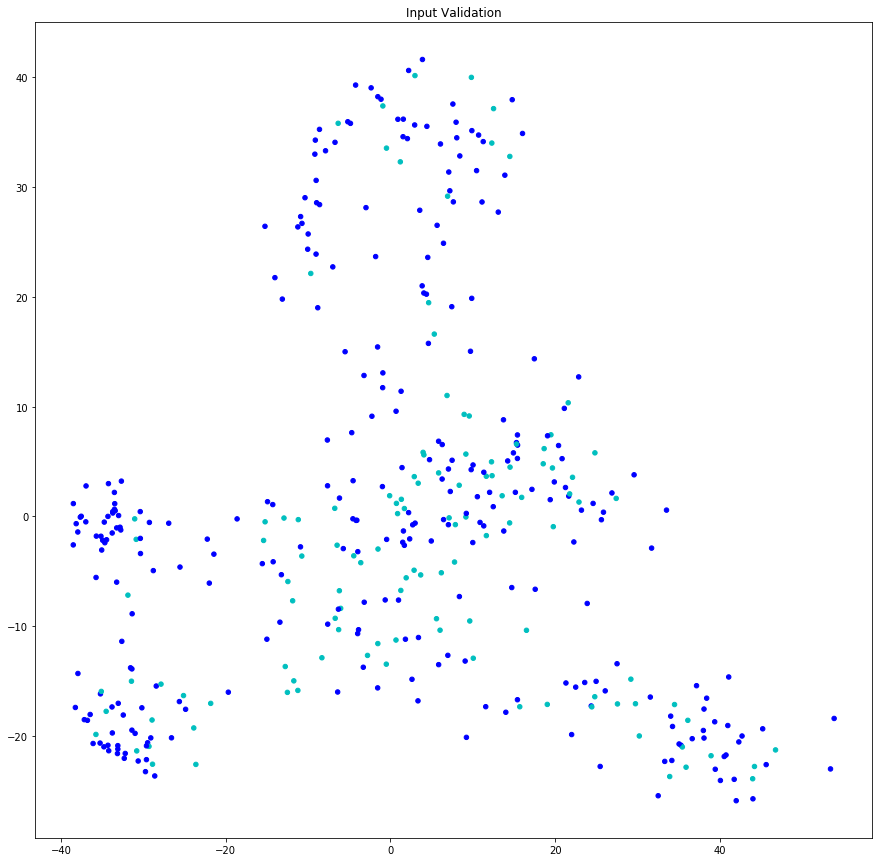

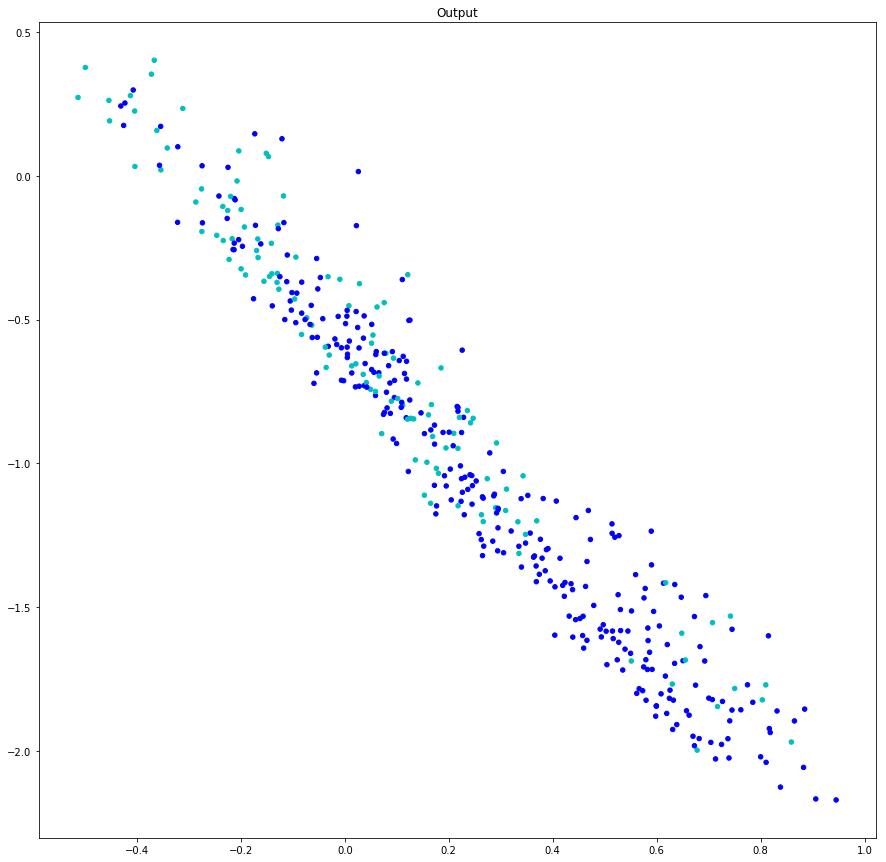

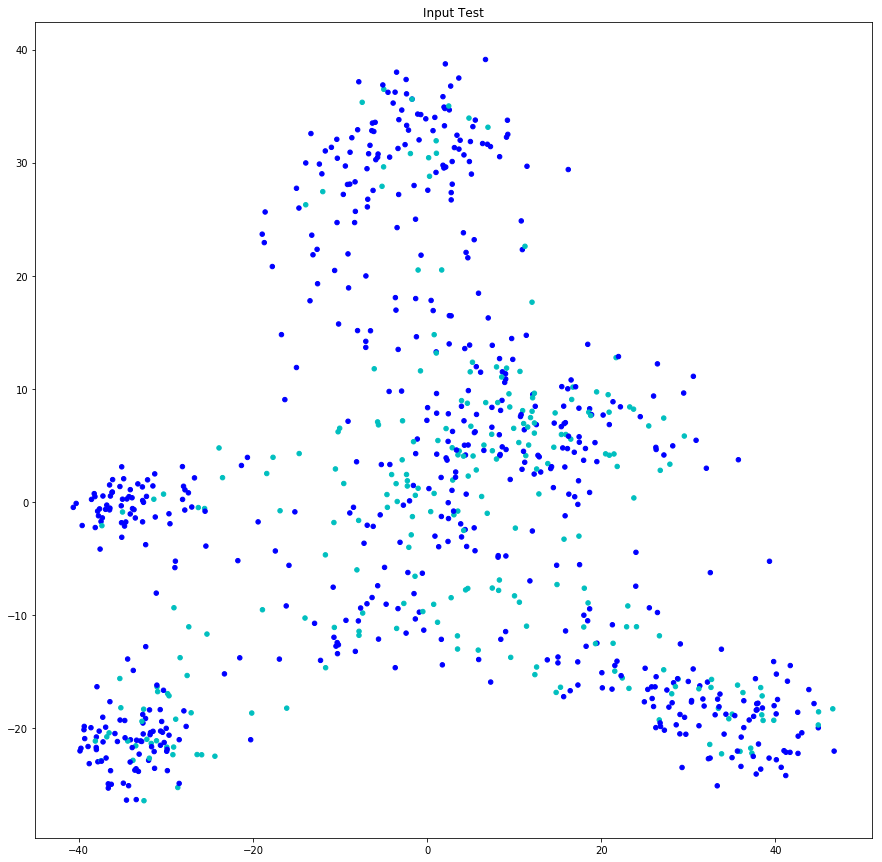

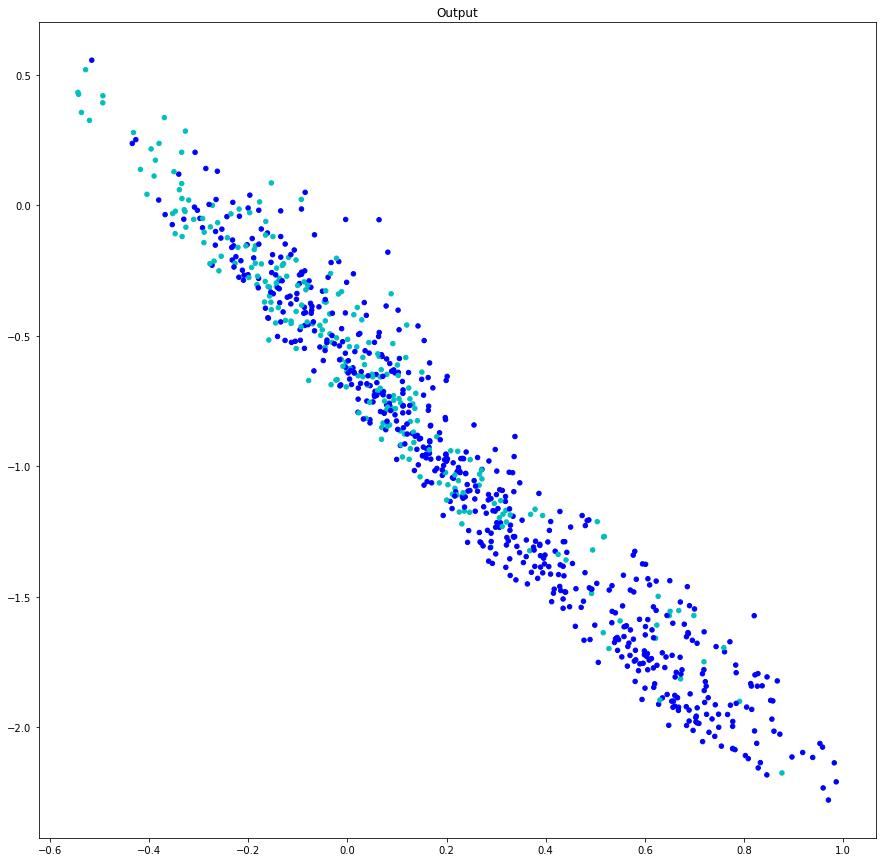

In [18]:
metric = get_result(model, best_model, best_val_acc, best_epoch, x_train, y_train, x_val, y_val, 
                    x_test, y_test, batch_size, multi_heads, show_results_in_notebook, 
                    loss_idx=0, acc_idx=0)

In [19]:
loss_his_all.append([loss_train_his, loss_val_his, loss_test_his])
acc_his_all.append([acc_train_his, acc_val_his, acc_test_his])
metric_all.append([v[0] for v in metric])
confusion_mat_all.append([v[1] for v in metric])

# Factorization AutoEncoder

In [20]:
def run_one_model(model, loss_weights, other_loss_weights, 
                  loss_his_all=[], acc_his_all=[], metric_all=[], confusion_mat_all=[],
                  heads=[0,1], multi_heads=True, return_results=False, 
                  loss_fns=loss_fns, other_loss_fns=other_loss_fns, 
                  lr=lr, weight_decay=weight_decay, batch_size=batch_size, 
                  num_epochs=num_epochs, reduce_every=reduce_every, eval_every=eval_every, 
                  print_every=print_every, x_train=x_train, y_train=y_train,
                  x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test,
                  show_results_in_notebook=show_results_in_notebook):
  """Train a model and get results  
    Most of the parameters are from the context; handle it properly
  """
  loss_train_his = []
  loss_val_his = []
  loss_test_his = []
  acc_train_his = []
  acc_val_his = []
  acc_test_his = []
  best_model = model
  best_val_acc = 0
  best_epoch = 0

  best_model, best_val_acc, best_epoch = train_multiloss(model, x_train, [y_train, x_train], 
    x_val, [y_val, x_val], x_test, [y_test, x_test], heads=heads, loss_fns=loss_fns, 
    loss_weights=loss_weights, other_loss_fns=other_loss_fns, 
    other_loss_weights=other_loss_weights, 
    lr=lr, weight_decay=weight_decay, batch_size=batch_size, num_epochs=num_epochs, 
    reduce_every=reduce_every, eval_every=eval_every, print_every=print_every,
    loss_train_his=loss_train_his, loss_val_his=loss_val_his, loss_test_his=loss_test_his, 
    acc_train_his=acc_train_his, acc_val_his=acc_val_his, acc_test_his=acc_test_his, 
    return_best_val=True, amsgrad=True, verbose=False)

  metric = get_result(model, best_model, best_val_acc, best_epoch, x_train, y_train, x_val, y_val, 
                      x_test, y_test, batch_size, multi_heads, show_results_in_notebook, 
                      loss_idx=0, acc_idx=0)

  loss_his_all.append([loss_train_his, loss_val_his, loss_test_his])
  acc_his_all.append([acc_train_his, acc_val_his, acc_test_his])
  metric_all.append([v[0] for v in metric])
  confusion_mat_all.append([v[1] for v in metric])
  
  if return_results:
    return loss_his_all, acc_his_all, metric_all, confusion_mat_all

Plain AutoEncoder model
Epoch0 Train: loss:7.10e-01, 1.17e+00, acc=0.58
Epoch0 Test: loss:6.23e-01, 1.06e+00, acc=0.71
epoch 0, best_val_acc=0.71, train_acc=0.58
Epoch0 Test: loss:6.27e-01, 1.06e+00, acc=0.71
epoch 7, best_val_acc=0.71, train_acc=0.71
epoch 8, best_val_acc=0.73, train_acc=0.72
epoch 21, best_val_acc=0.73, train_acc=0.79
Epoch100 Train: loss:9.29e-02, 2.24e-01, acc=0.99
Epoch100 Test: loss:9.50e-01, 2.22e-01, acc=0.69
Epoch100 Test: loss:9.61e-01, 2.21e-01, acc=0.70
Epoch200 Train: loss:8.76e-03, 1.85e-01, acc=1.00
Epoch200 Test: loss:1.31e+00, 1.86e-01, acc=0.69
Epoch200 Test: loss:1.33e+00, 1.87e-01, acc=0.67
Epoch300 Train: loss:1.99e-03, 1.67e-01, acc=1.00
Epoch300 Test: loss:1.66e+00, 1.68e-01, acc=0.69
Epoch300 Test: loss:1.72e+00, 1.69e-01, acc=0.67
Epoch400 Train: loss:8.28e-04, 1.56e-01, acc=1.00
Epoch400 Test: loss:1.94e+00, 1.57e-01, acc=0.70
Epoch400 Test: loss:2.07e+00, 1.59e-01, acc=0.67
Best model on validation set: best_val_acc=0.73, epoch=21
Train
acc=0

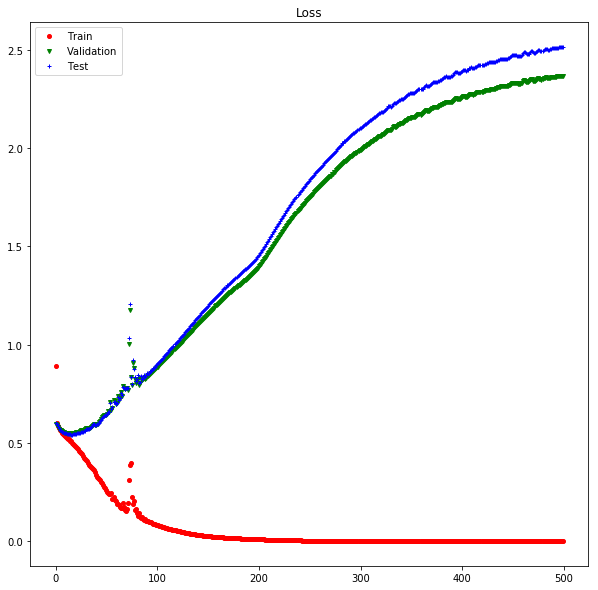

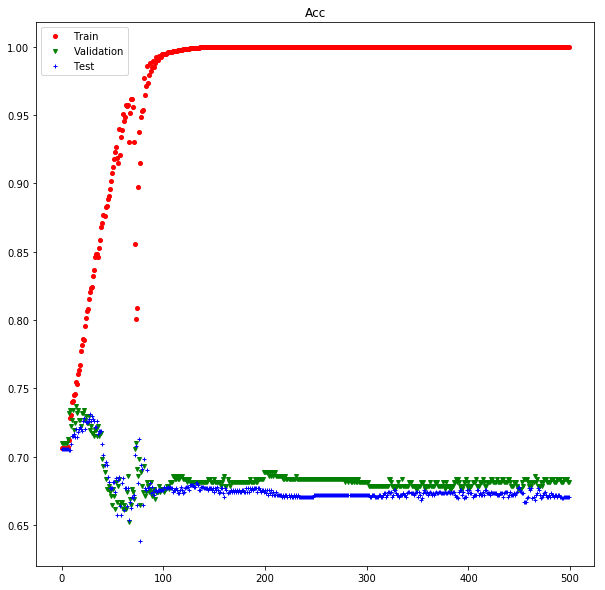

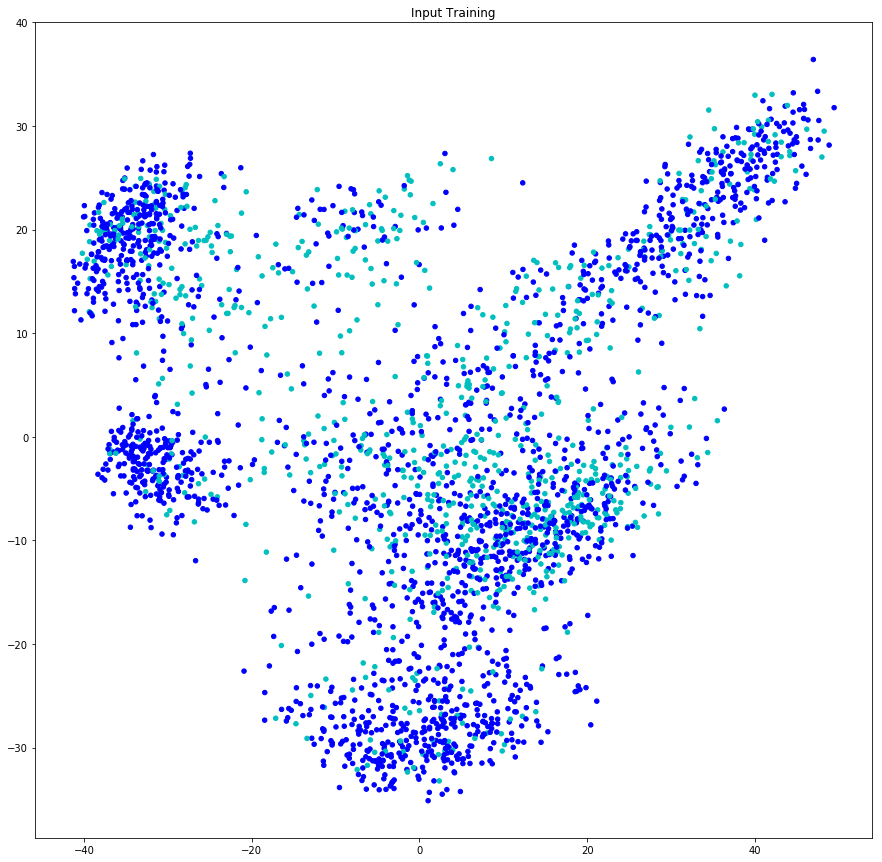

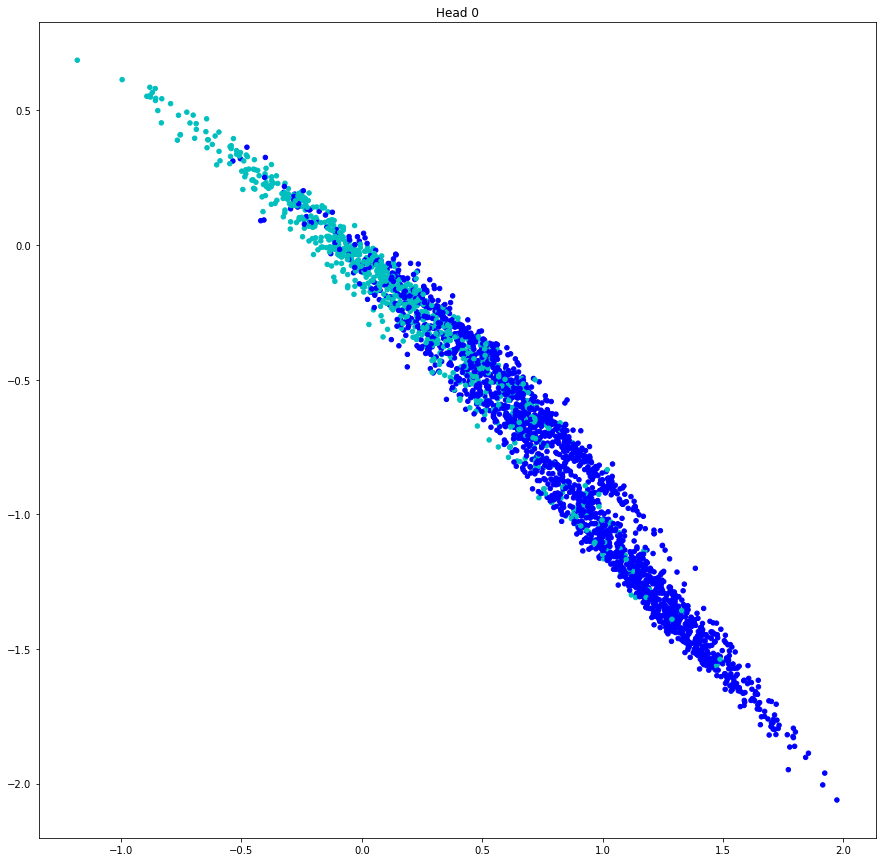

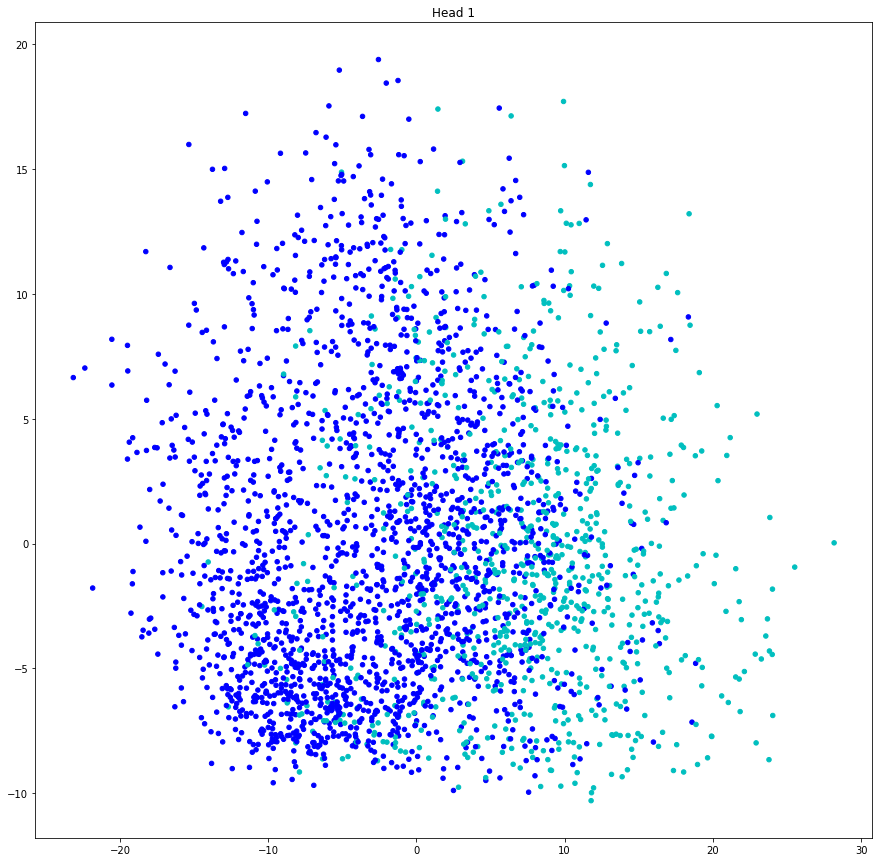

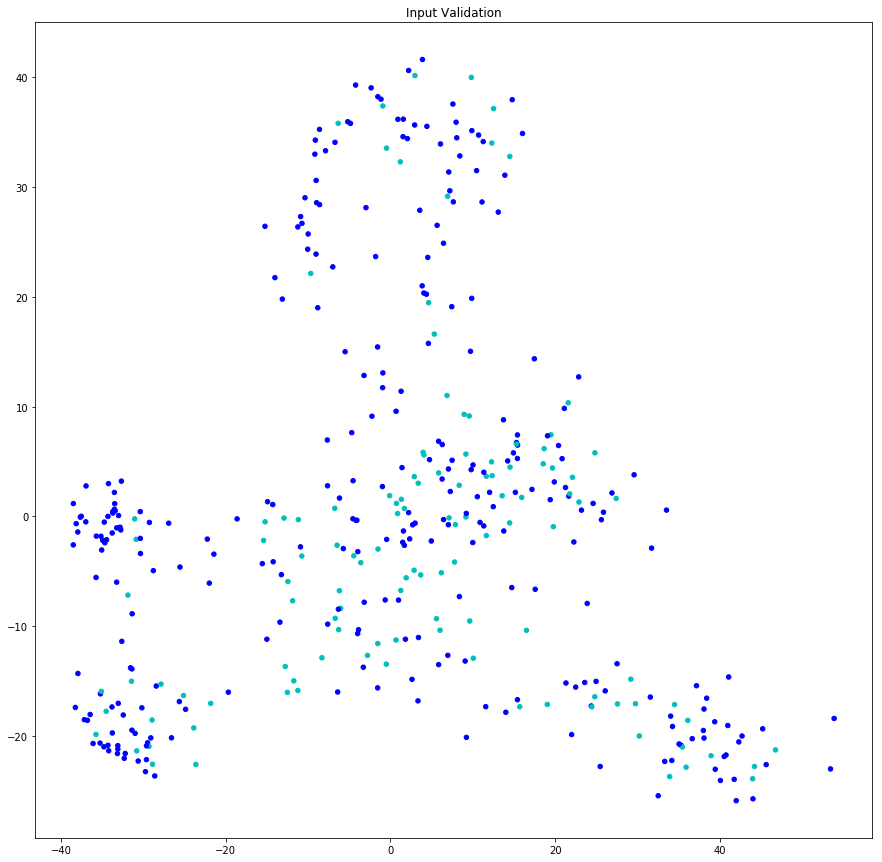

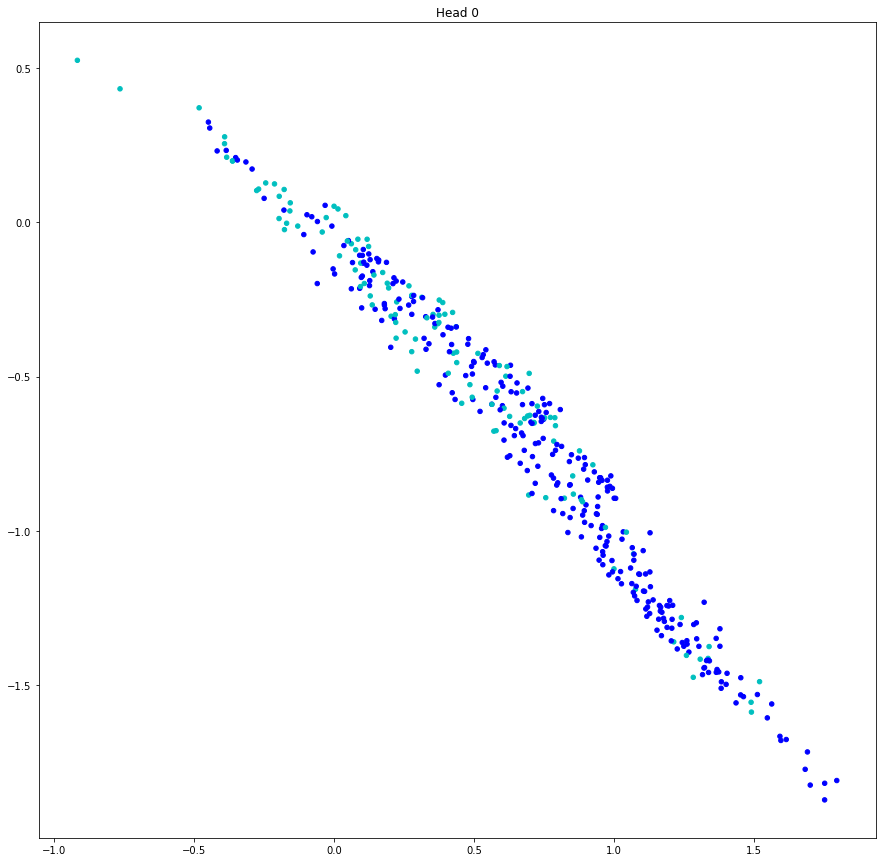

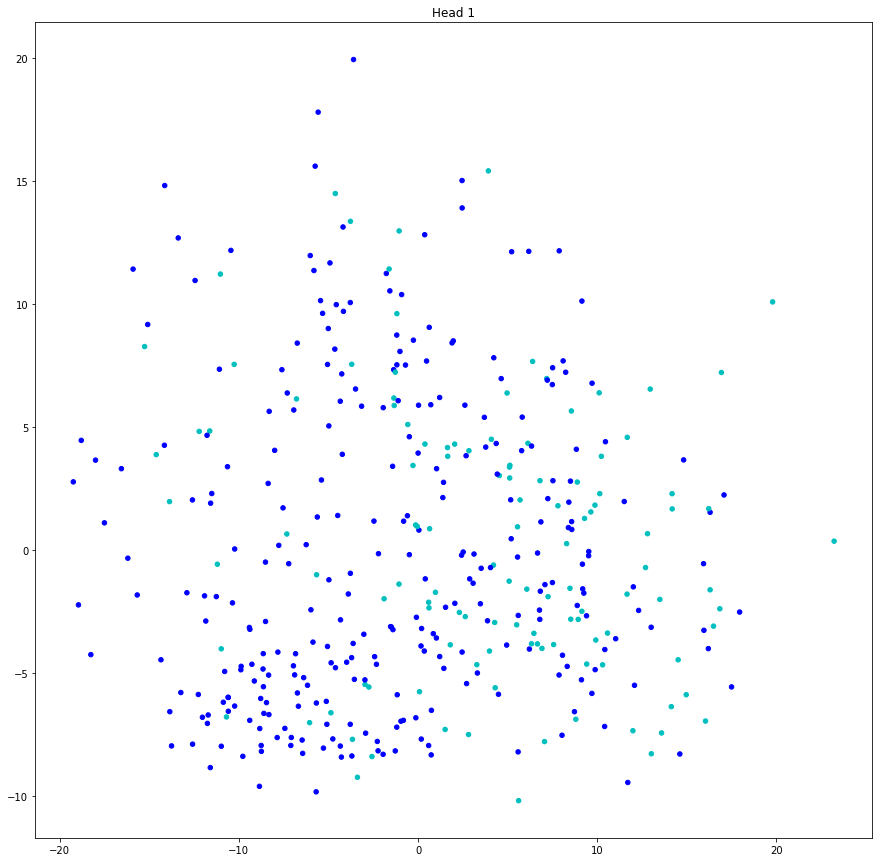

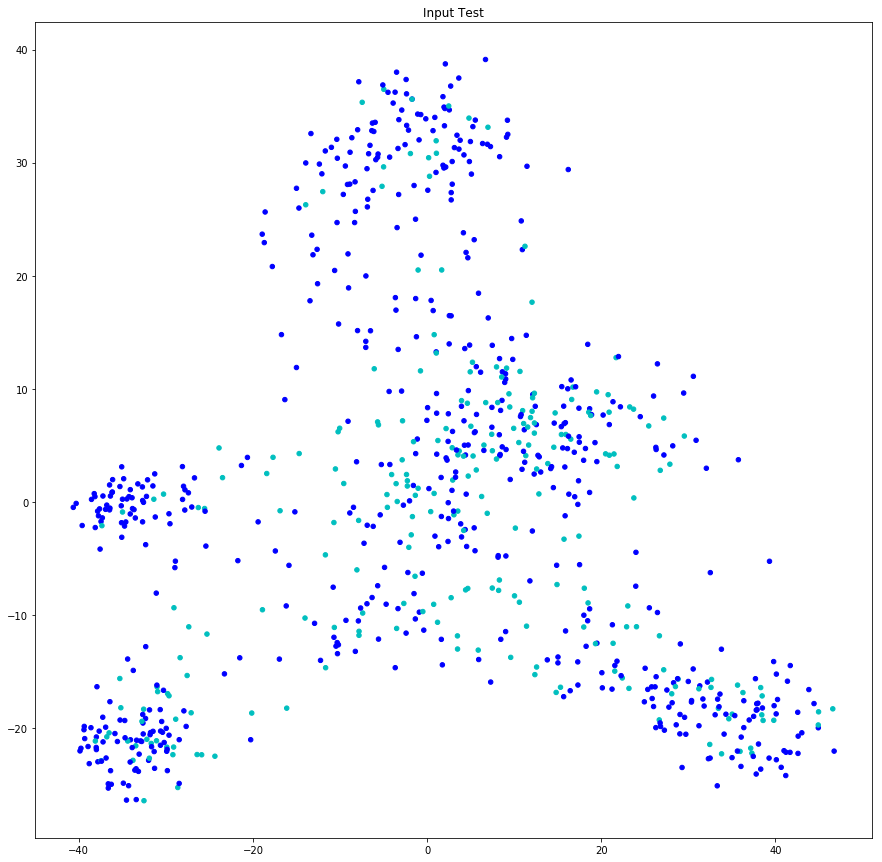

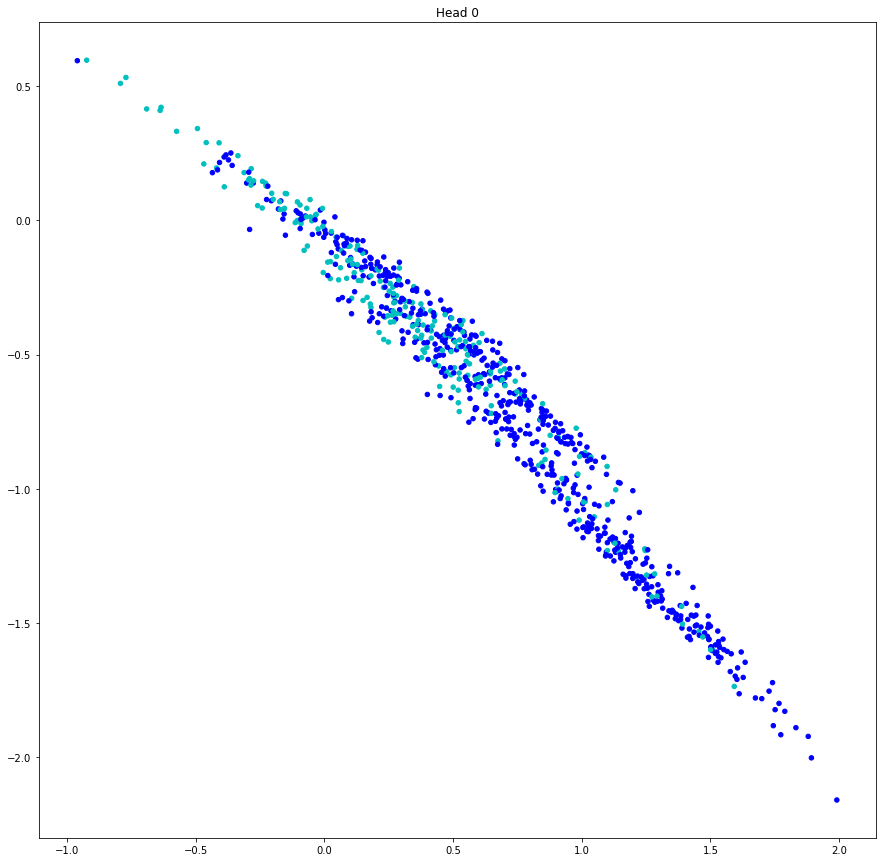

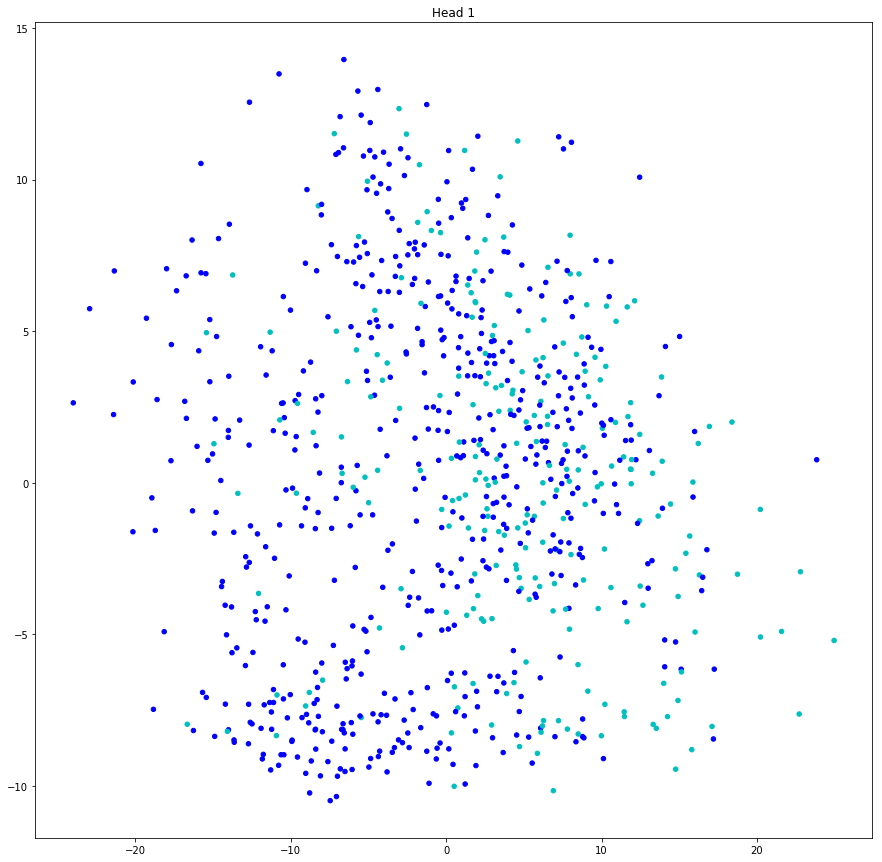

In [21]:
decoder_norm = False
uniform_decoder_norm = False
print('Plain AutoEncoder model')
model_names.append('AE')
model = AutoEncoder(in_dim, hidden_dim, num_cls, dense=dense, residual=residual,
          decoder_norm=decoder_norm, uniform_decoder_norm=uniform_decoder_norm).to(device)
loss_weights = [1,1]
other_loss_weights = [0]
# heads = None should work for all the following; keep this for clarity
heads = [0,1] 
run_one_model(model, loss_weights, other_loss_weights,
              loss_his_all, acc_his_all, metric_all, confusion_mat_all,
              heads=heads, multi_heads=True, return_results=False, 
              loss_fns=loss_fns, other_loss_fns=other_loss_fns, 
              lr=lr, weight_decay=weight_decay, batch_size=batch_size, 
              num_epochs=num_epochs, reduce_every=reduce_every, eval_every=eval_every, 
              print_every=print_every, x_train=x_train, y_train=y_train,
              x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test,
              show_results_in_notebook=show_results_in_notebook)

## Add feature interaction network regularizer

MultiviewAE with feature interaction network regularizer
Epoch0 Train: loss:6.33e-01, 1.04e+00, 2.03e+00, acc=0.59
Epoch0 Test: loss:6.02e-01, 1.00e+00, 2.02e+00, acc=0.71
epoch 0, best_val_acc=0.71, train_acc=0.59
Epoch0 Test: loss:6.04e-01, 1.00e+00, 2.02e+00, acc=0.71
epoch 7, best_val_acc=0.71, train_acc=0.71
epoch 9, best_val_acc=0.72, train_acc=0.72
epoch 11, best_val_acc=0.72, train_acc=0.73
epoch 12, best_val_acc=0.73, train_acc=0.74
epoch 13, best_val_acc=0.73, train_acc=0.74
Epoch100 Train: loss:4.97e-02, 2.02e-01, 4.88e-02, acc=1.00
Epoch100 Test: loss:9.22e-01, 2.02e-01, 4.81e-02, acc=0.68
Epoch100 Test: loss:9.02e-01, 2.02e-01, 4.81e-02, acc=0.70
Epoch200 Train: loss:5.47e-03, 1.73e-01, 1.77e-02, acc=1.00
Epoch200 Test: loss:1.31e+00, 1.73e-01, 1.76e-02, acc=0.68
Epoch200 Test: loss:1.29e+00, 1.75e-01, 1.76e-02, acc=0.69
Epoch300 Train: loss:2.32e-03, 1.65e-01, 1.32e-02, acc=1.00
Epoch300 Test: loss:1.49e+00, 1.66e-01, 1.32e-02, acc=0.69
Epoch300 Test: loss:1.47e+00, 1.67e

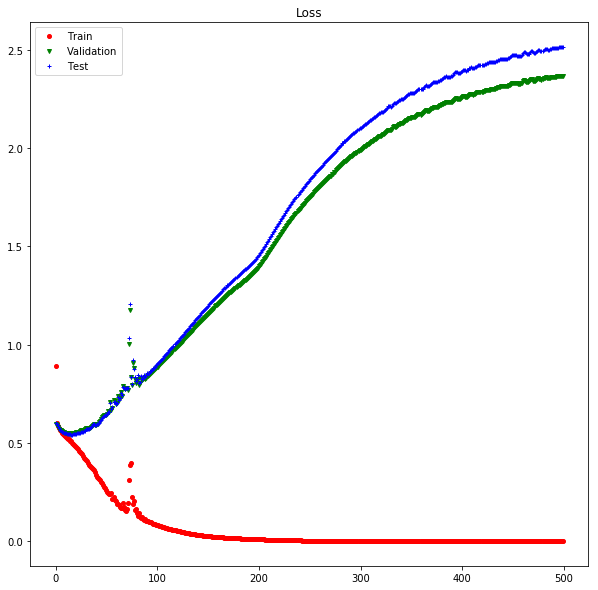

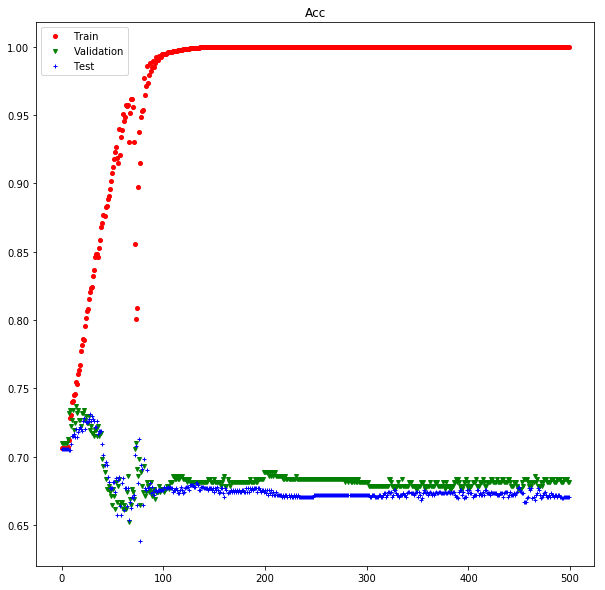

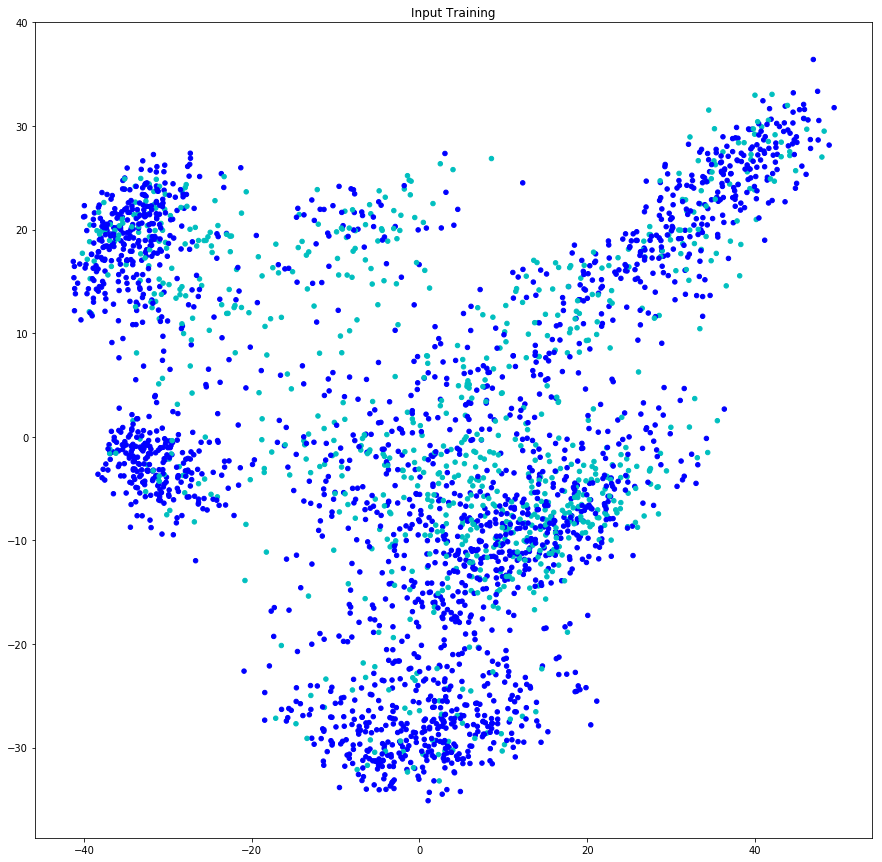

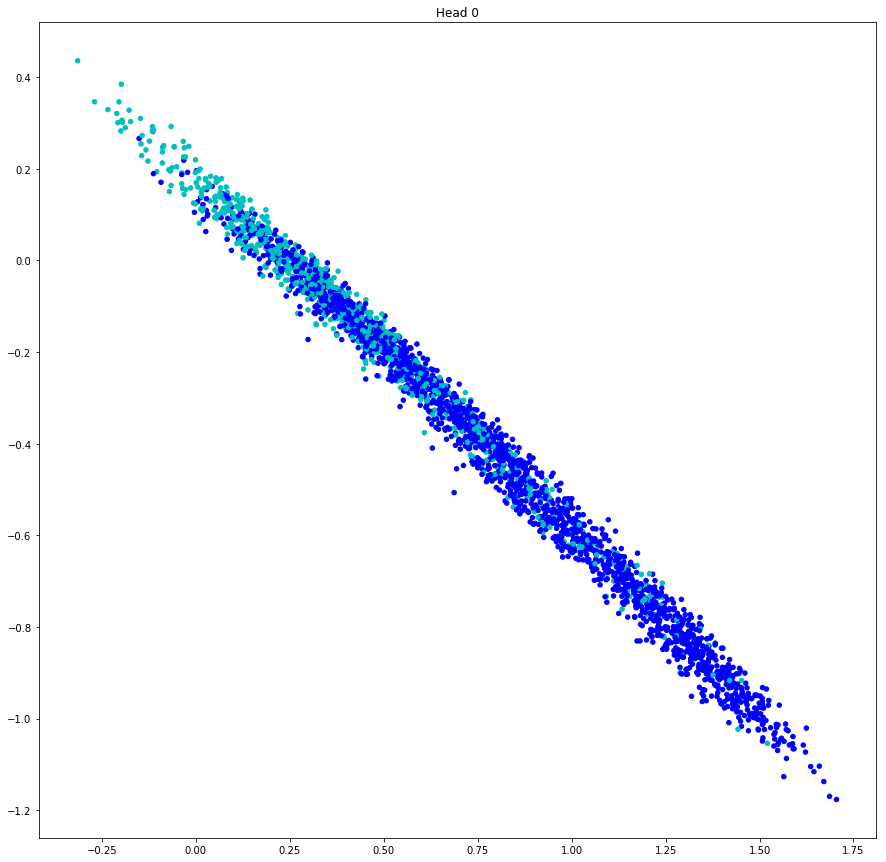

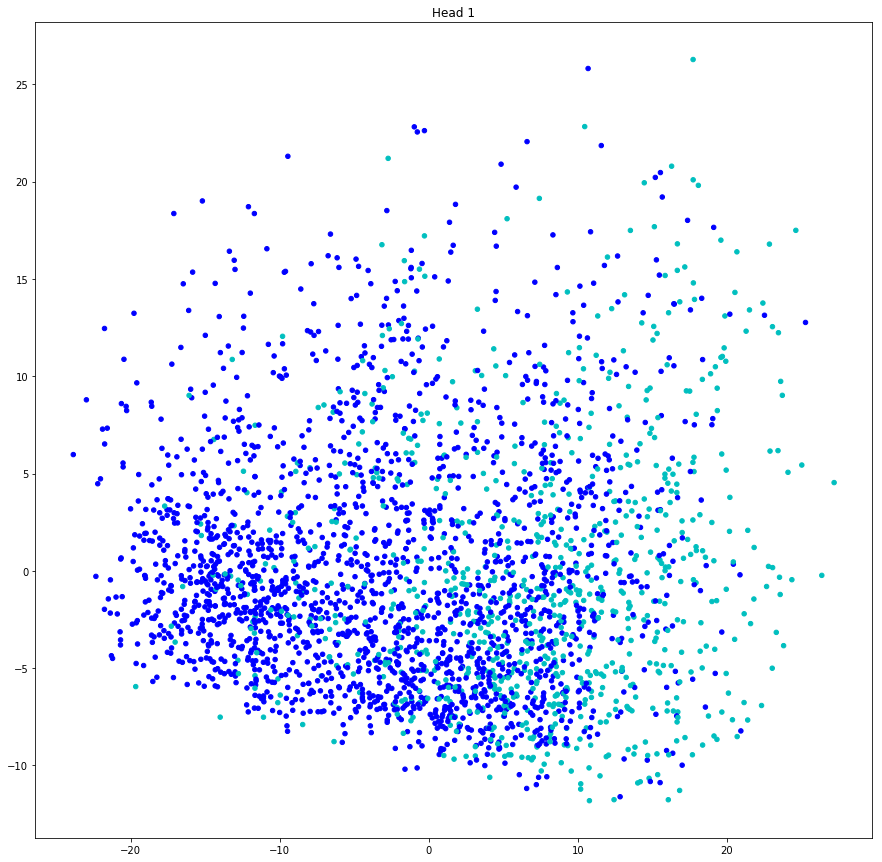

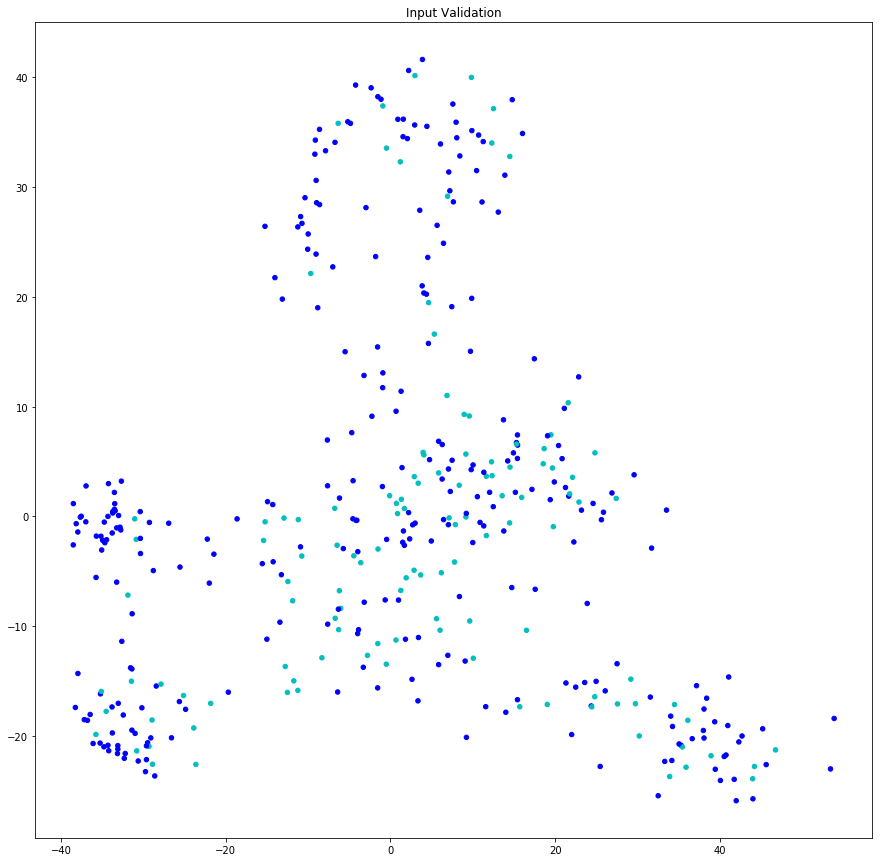

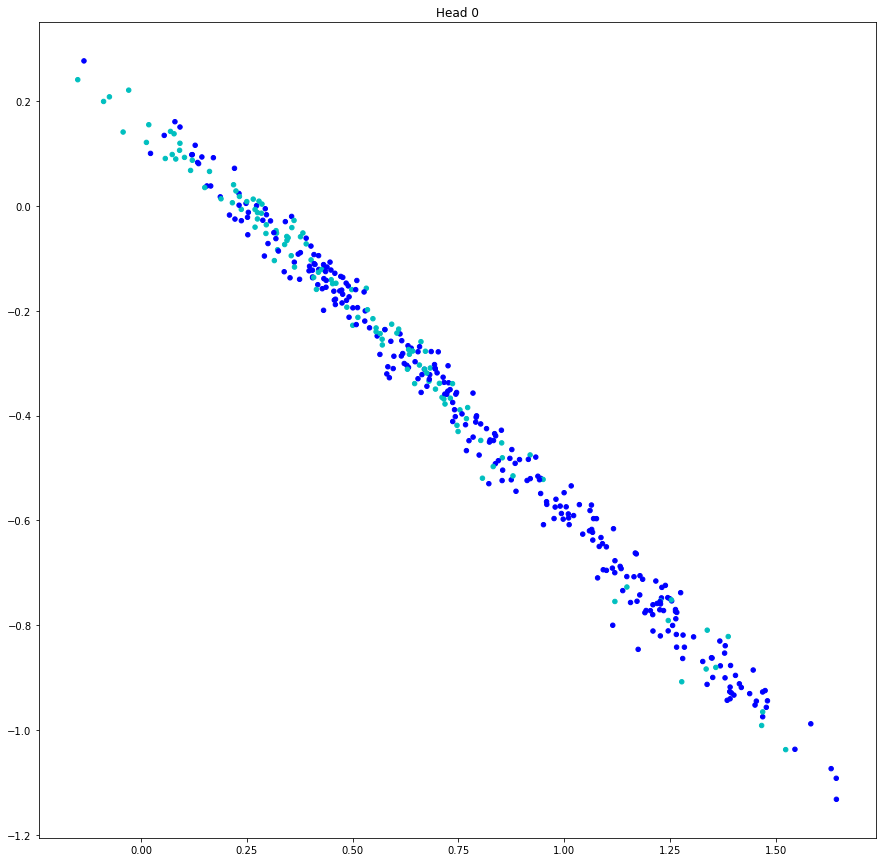

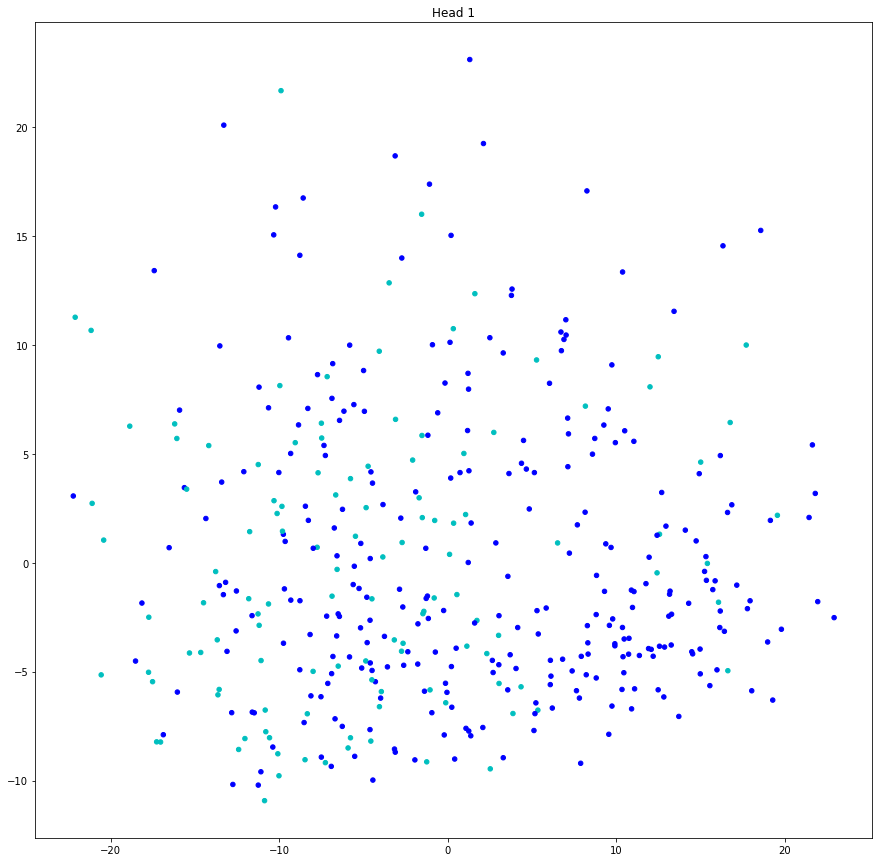

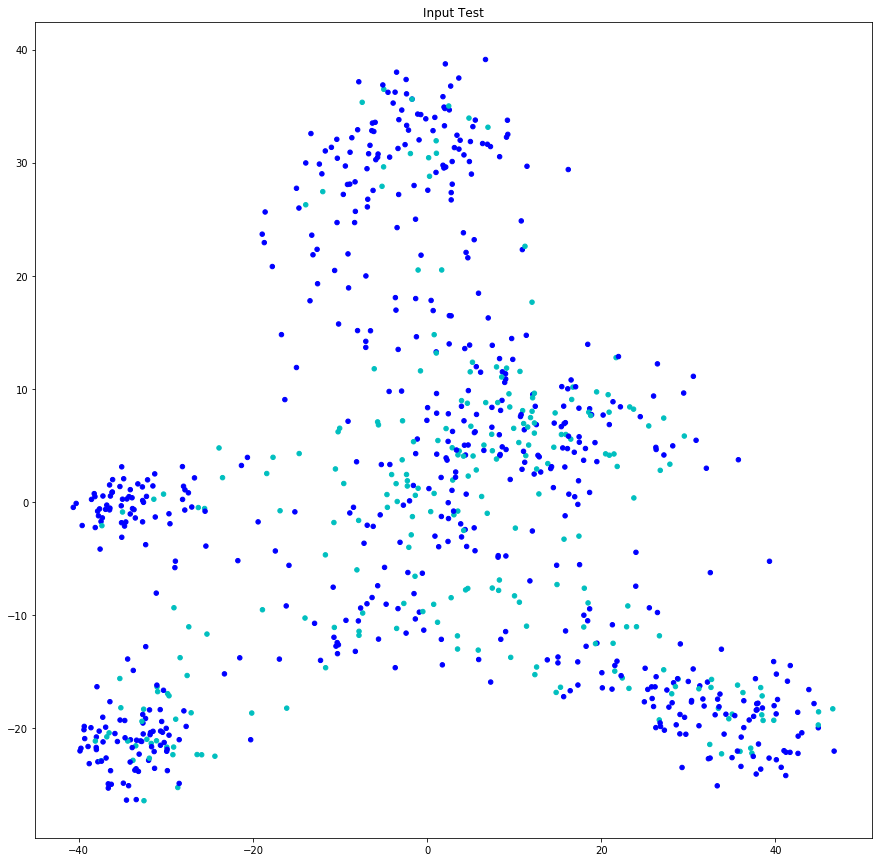

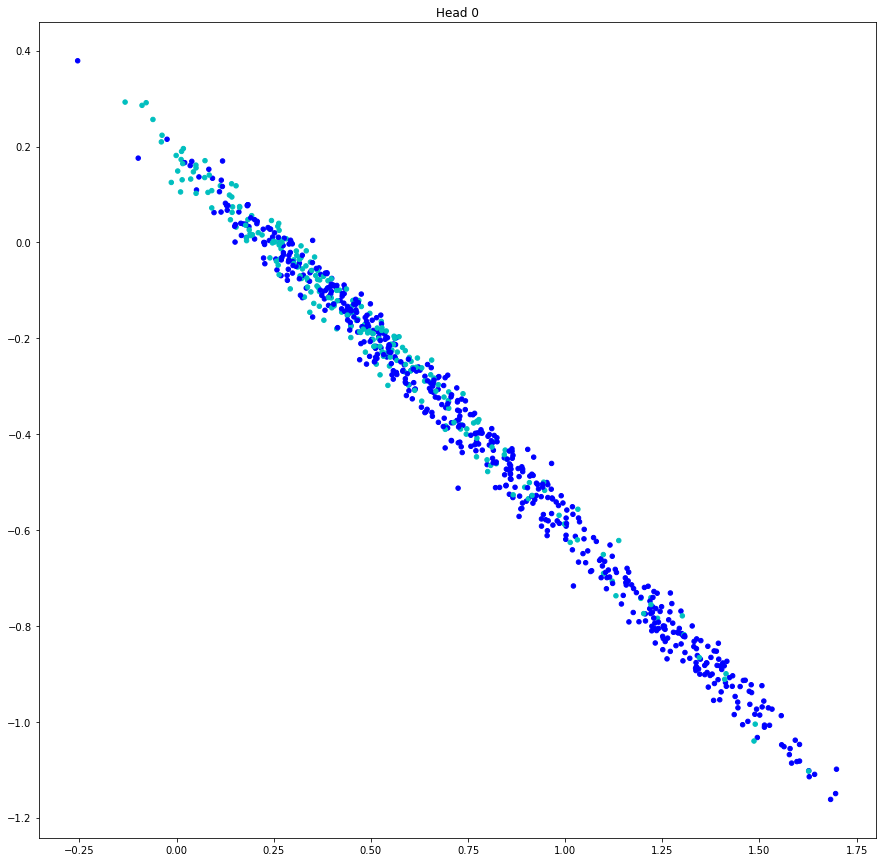

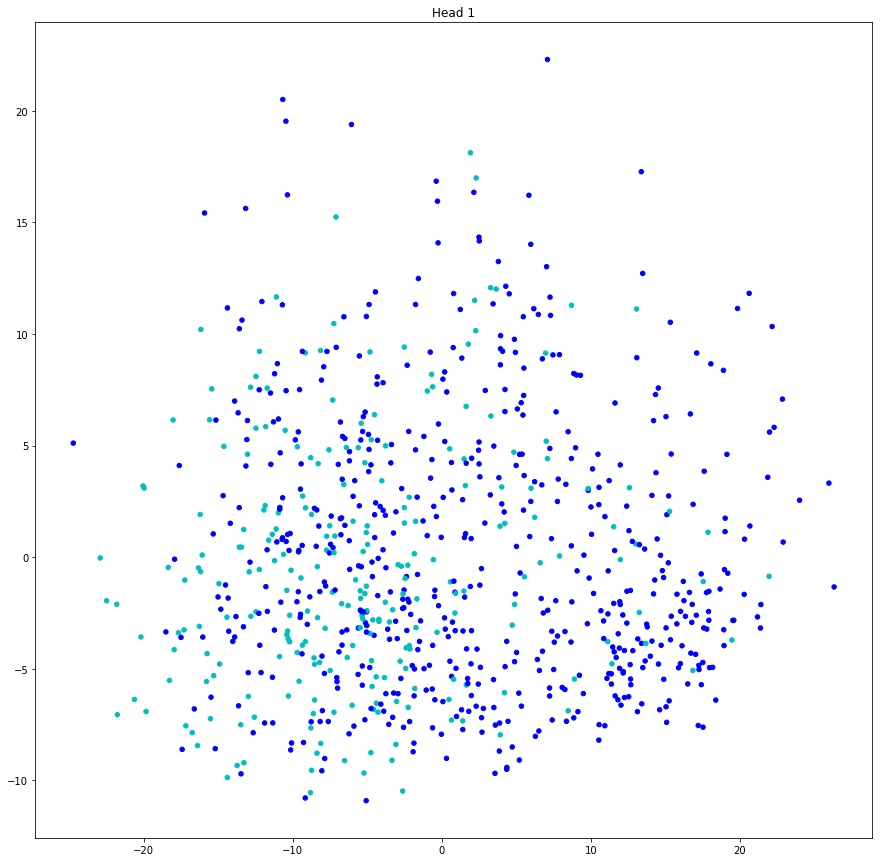

In [22]:
if num_data_types > 1:
  fuse_type = 'sum'
  print('MultiviewAE with feature interaction network regularizer')
  model_names.append('MultiviewAE + feat_int')
  model = MultiviewAE(in_dims=in_dims, hidden_dims=hidden_dim, out_dim=num_cls, 
                      fuse_type=fuse_type, dense=dense, residual=residual, 
                      residual_layers='all', decoder_norm=decoder_norm, 
                      decoder_norm_dim=0, uniform_decoder_norm=uniform_decoder_norm, 
                      nonlinearity=nn.ReLU(), last_nonlinearity=True, bias=True).to(device)
else:
  print('AutoEncoder with feature interaction network regularizer')
  model_names.append('AE + feat_int')
  model = AutoEncoder(in_dim, hidden_dim, num_cls, dense=dense, residual=residual, 
          decoder_norm=decoder_norm, uniform_decoder_norm=uniform_decoder_norm).to(device)

loss_weights = [1,1]
other_loss_weights = [1]
heads = [0,1]
run_one_model(model, loss_weights, other_loss_weights, 
              loss_his_all, acc_his_all, metric_all, confusion_mat_all,
              heads=heads, multi_heads=True, return_results=False, 
              loss_fns=loss_fns, other_loss_fns=other_loss_fns, 
              lr=lr, weight_decay=weight_decay, batch_size=batch_size, 
              num_epochs=num_epochs, reduce_every=reduce_every, eval_every=eval_every, 
              print_every=print_every, x_train=x_train, y_train=y_train,
              x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test,
              show_results_in_notebook=show_results_in_notebook)

## For multi-view data, add view similarity network regularizer

Run plain MultiviewAE model
Epoch0 Train: loss:6.20e-01, 1.03e+00, acc=0.71
Epoch0 Test: loss:6.00e-01, 9.98e-01, acc=0.71
epoch 0, best_val_acc=0.71, train_acc=0.71
Epoch0 Test: loss:6.03e-01, 9.98e-01, acc=0.71
epoch 6, best_val_acc=0.71, train_acc=0.71
epoch 7, best_val_acc=0.72, train_acc=0.71
epoch 9, best_val_acc=0.72, train_acc=0.73
epoch 10, best_val_acc=0.72, train_acc=0.73
epoch 15, best_val_acc=0.72, train_acc=0.76
epoch 18, best_val_acc=0.73, train_acc=0.77
epoch 19, best_val_acc=0.73, train_acc=0.77
Epoch100 Train: loss:6.70e-02, 1.87e-01, acc=1.00
Epoch100 Test: loss:8.53e-01, 1.87e-01, acc=0.69
Epoch100 Test: loss:8.68e-01, 1.88e-01, acc=0.69
Epoch200 Train: loss:9.80e-03, 1.57e-01, acc=1.00
Epoch200 Test: loss:1.23e+00, 1.58e-01, acc=0.69
Epoch200 Test: loss:1.24e+00, 1.59e-01, acc=0.68
Epoch300 Train: loss:2.97e-03, 1.44e-01, acc=1.00
Epoch300 Test: loss:1.51e+00, 1.45e-01, acc=0.68
Epoch300 Test: loss:1.51e+00, 1.46e-01, acc=0.68
Epoch400 Train: loss:1.57e-03, 1.39e-0

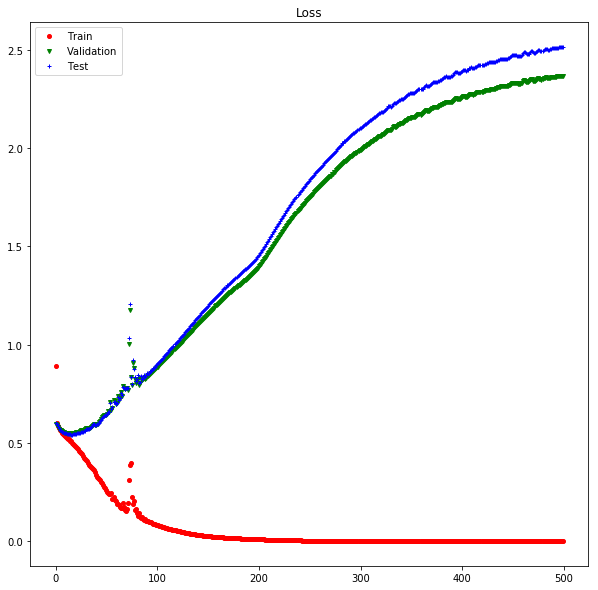

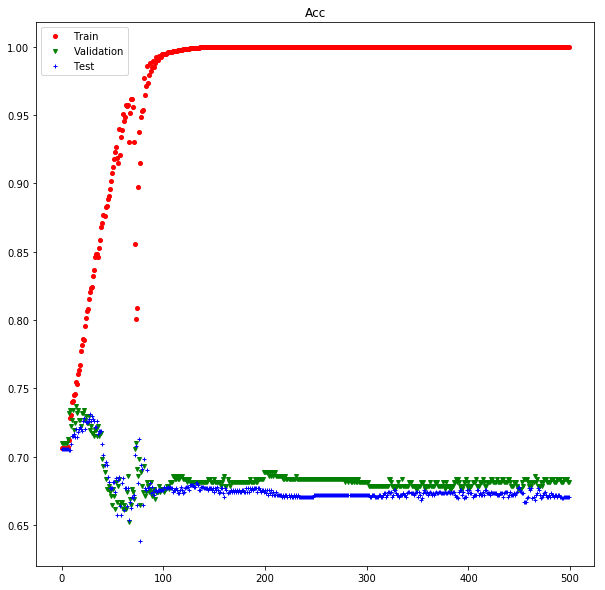

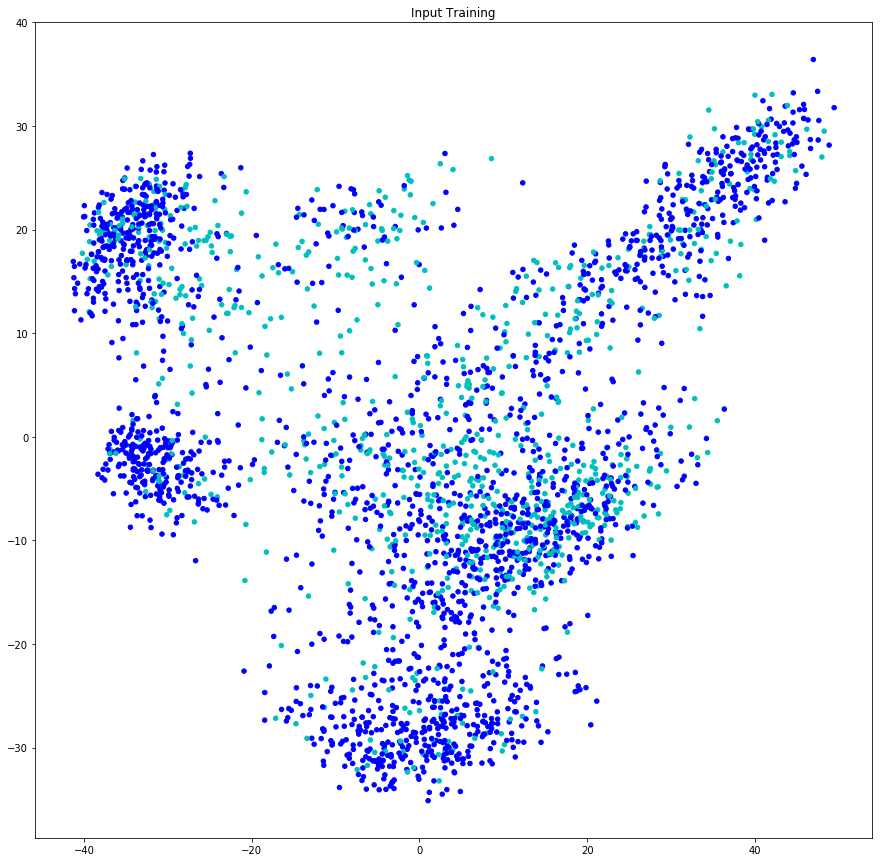

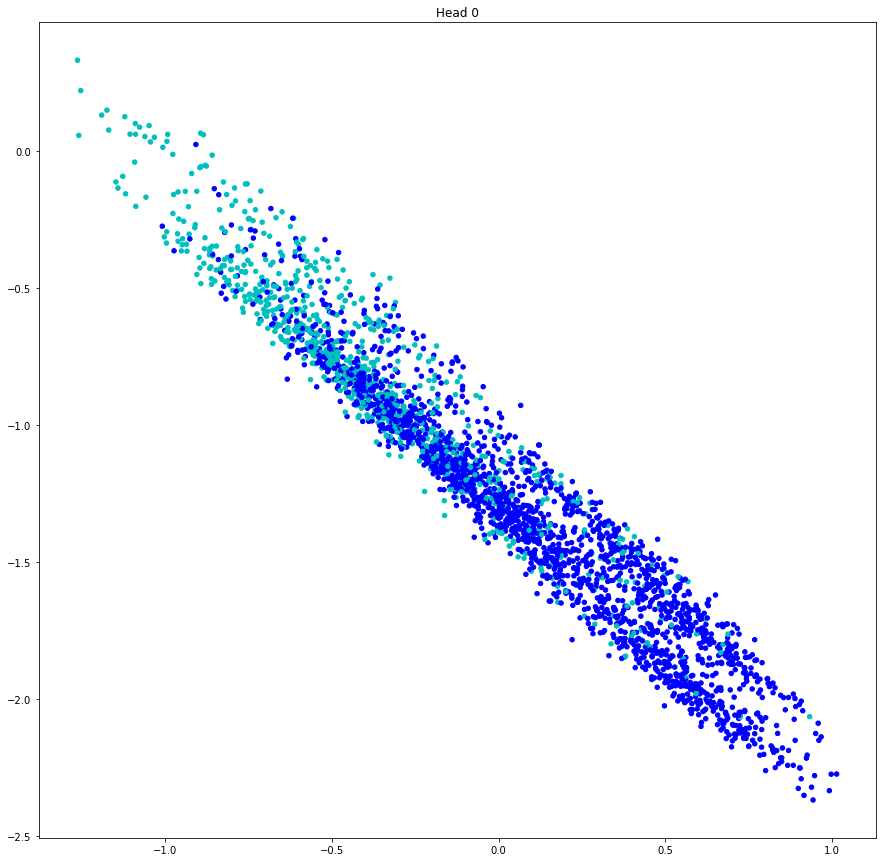

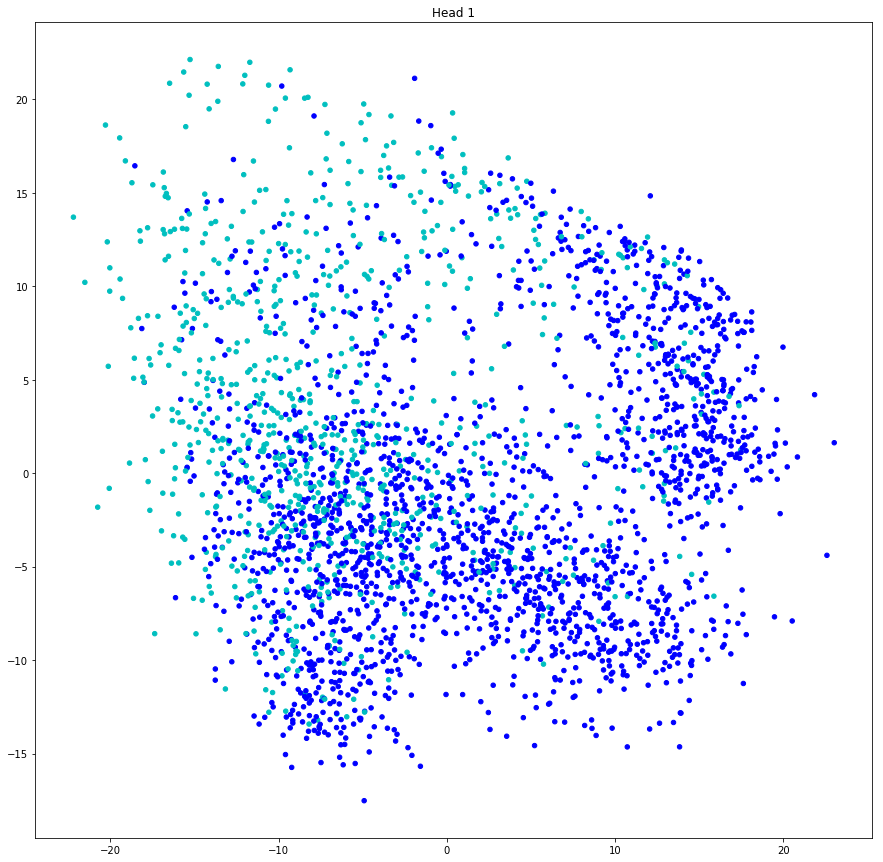

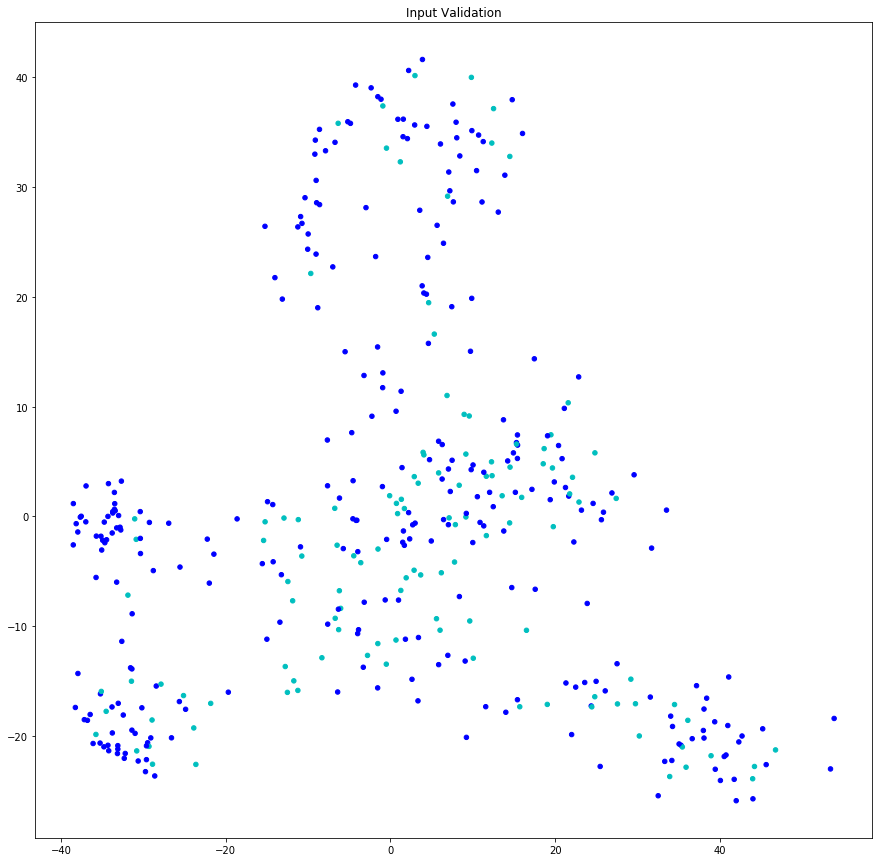

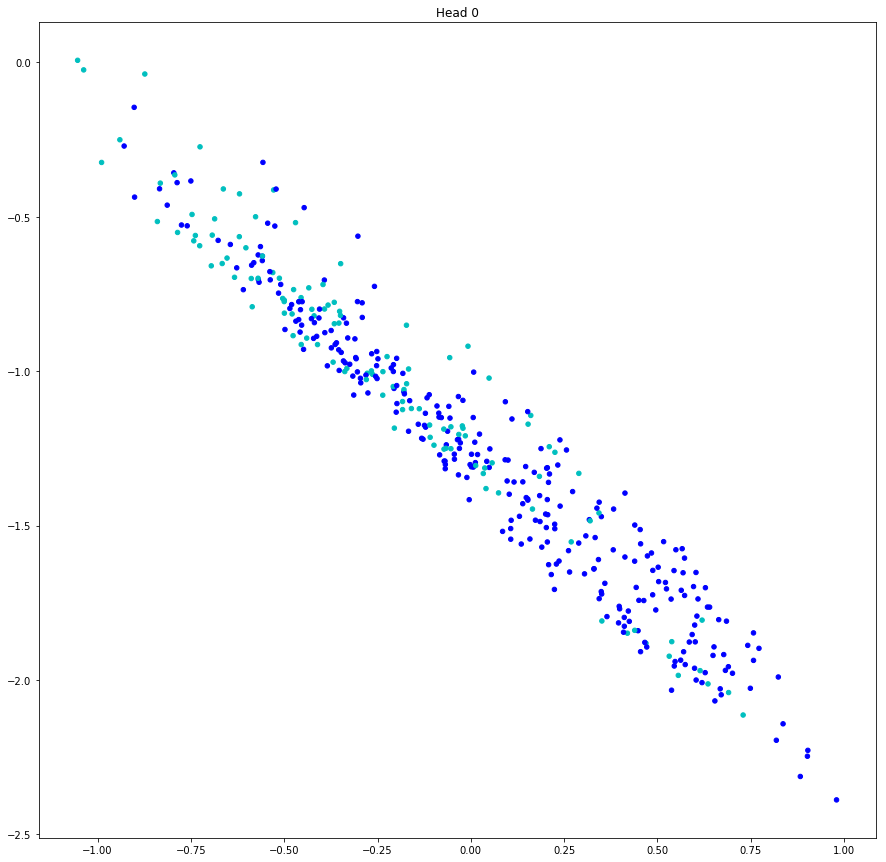

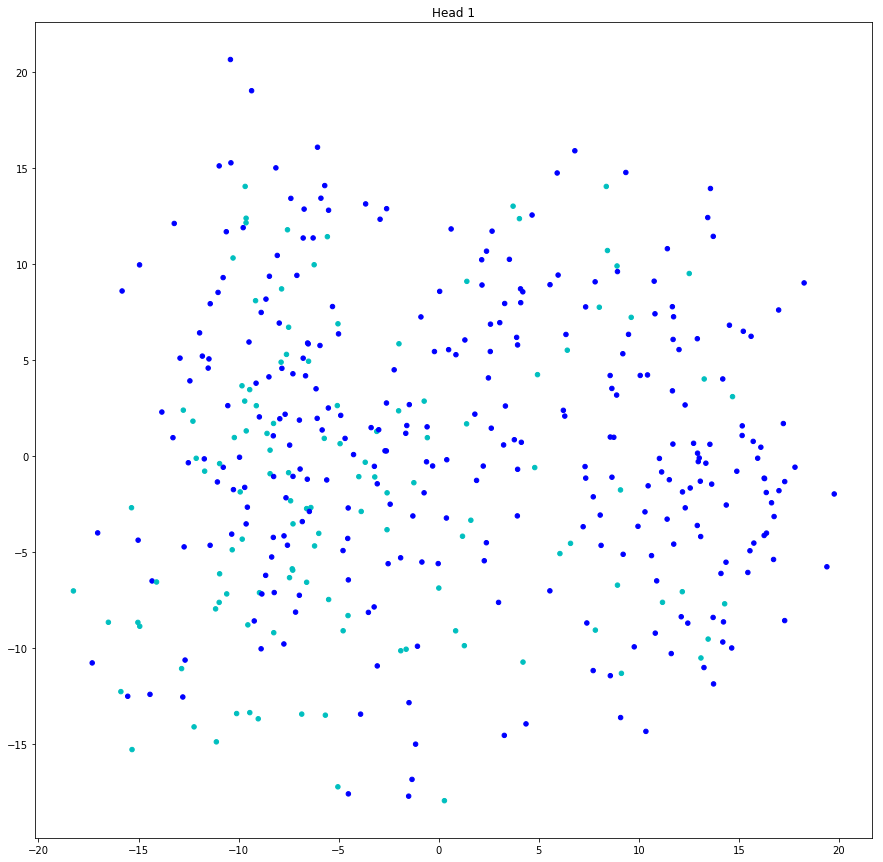

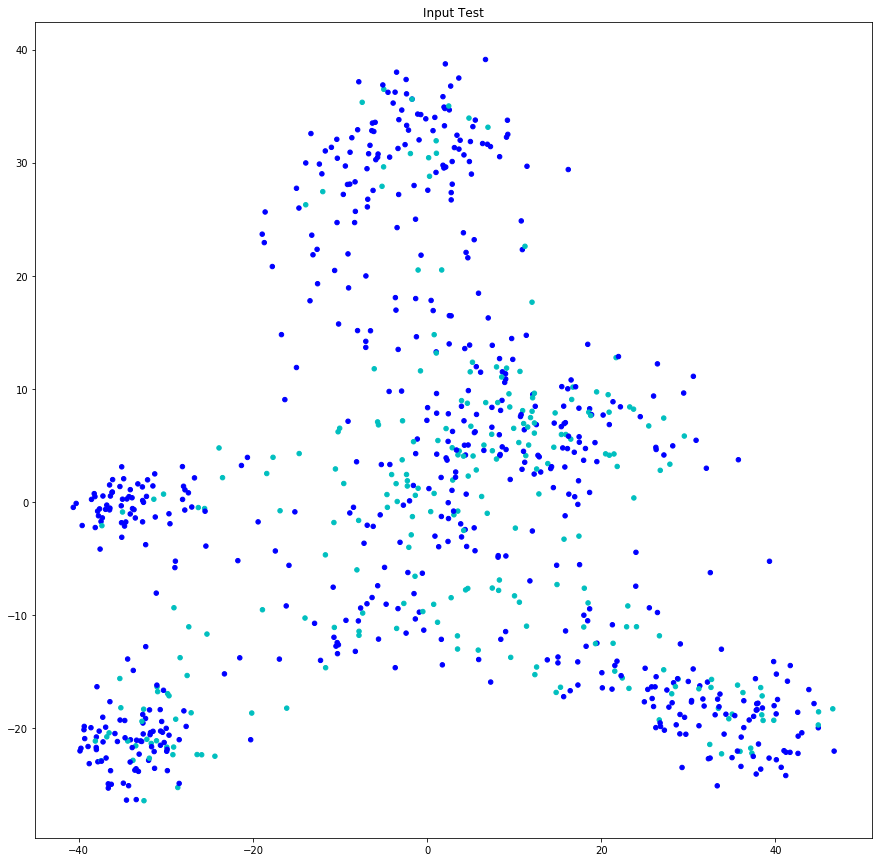

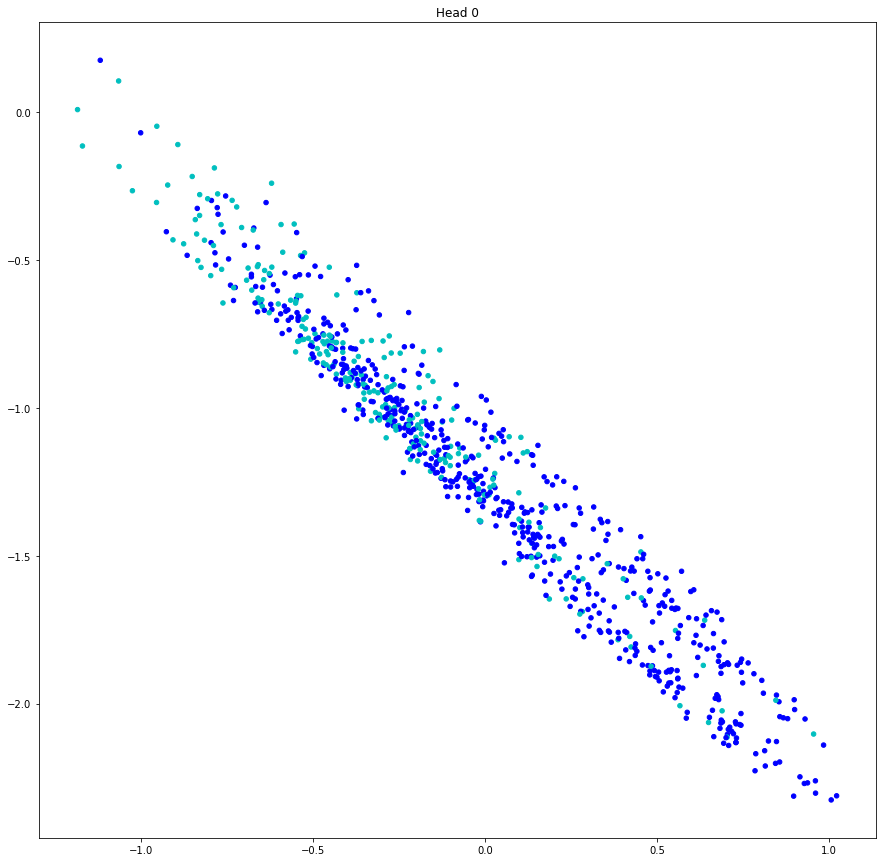

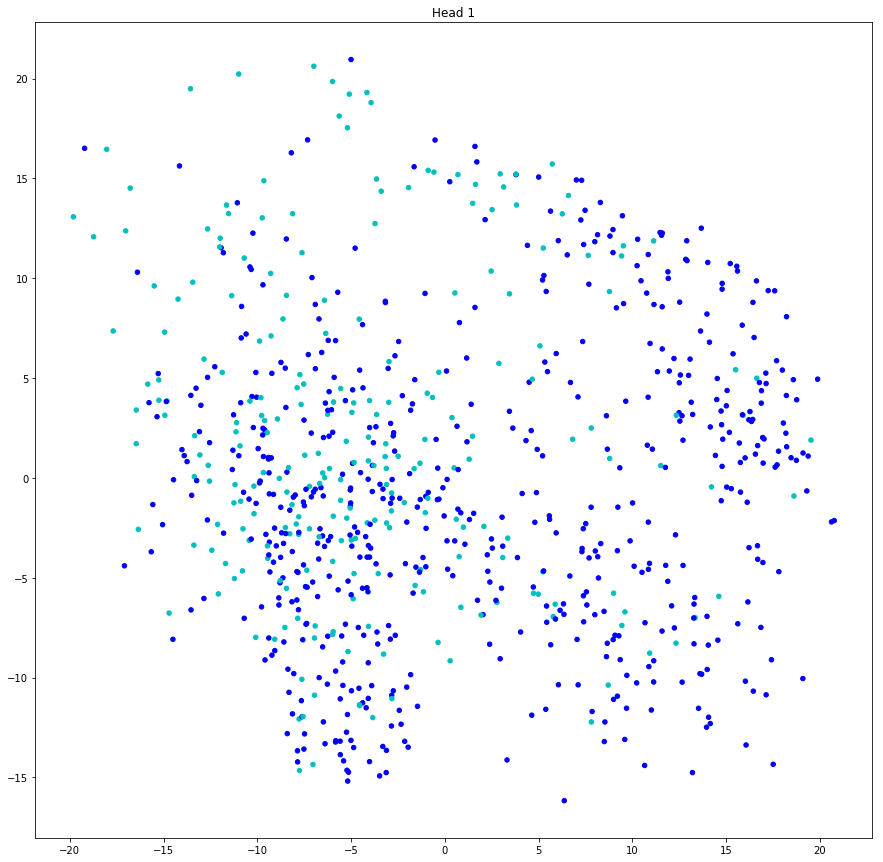

In [23]:
if num_data_types > 1:
  # plain multiviewAE; compare it with plain AutoEncoder to see 
  # if separating views in lower layers in MultiviewAE is better than combining them all the way
  print('Run plain MultiviewAE model')
  model_names.append('MultiviewAE')
  model = MultiviewAE(in_dims=in_dims, hidden_dims=hidden_dim, out_dim=num_cls, 
                    fuse_type=fuse_type, dense=dense, residual=residual, 
                    residual_layers='all', decoder_norm=decoder_norm, 
                    decoder_norm_dim=0, uniform_decoder_norm=uniform_decoder_norm, 
                    nonlinearity=nn.ReLU(), last_nonlinearity=True, bias=True).to(device)

  loss_weights = [1,1]
  other_loss_weights = [0]
  heads = [0,1]
  run_one_model(model, loss_weights, other_loss_weights, 
                loss_his_all, acc_his_all, metric_all, confusion_mat_all,
                heads=heads, multi_heads=True, return_results=False, 
                loss_fns=loss_fns, other_loss_fns=other_loss_fns, 
                lr=lr, weight_decay=weight_decay, batch_size=batch_size, 
                num_epochs=num_epochs, reduce_every=reduce_every, eval_every=eval_every, 
                print_every=print_every, x_train=x_train, y_train=y_train,
                x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test,
                show_results_in_notebook=show_results_in_notebook)

MultiviewAE with view similarity regularizers
Epoch0 Train: loss:6.26e-01, 1.13e+00, -6.41e-01, acc=0.70
Epoch0 Test: loss:6.02e-01, 1.16e+00, -8.46e-01, acc=0.71
epoch 0, best_val_acc=0.71, train_acc=0.70
Epoch0 Test: loss:6.08e-01, 1.17e+00, -8.48e-01, acc=0.71
epoch 26, best_val_acc=0.71, train_acc=0.71
epoch 27, best_val_acc=0.71, train_acc=0.71
epoch 30, best_val_acc=0.72, train_acc=0.72
epoch 33, best_val_acc=0.72, train_acc=0.74
epoch 35, best_val_acc=0.72, train_acc=0.75
epoch 36, best_val_acc=0.72, train_acc=0.75
epoch 43, best_val_acc=0.73, train_acc=0.79
epoch 57, best_val_acc=0.73, train_acc=0.85
Epoch100 Train: loss:1.88e-01, 2.52e-01, -9.80e-01, acc=0.96
Epoch100 Test: loss:6.63e-01, 2.50e-01, -9.82e-01, acc=0.68
Epoch100 Test: loss:6.63e-01, 2.48e-01, -9.82e-01, acc=0.69
Epoch200 Train: loss:4.56e-02, 1.98e-01, -9.87e-01, acc=1.00
Epoch200 Test: loss:9.20e-01, 1.98e-01, -9.88e-01, acc=0.67
Epoch200 Test: loss:9.59e-01, 1.98e-01, -9.88e-01, acc=0.68
Epoch300 Train: loss:2

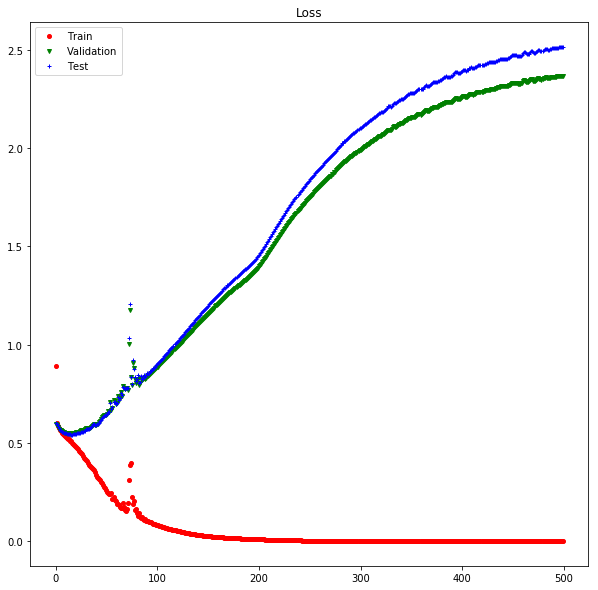

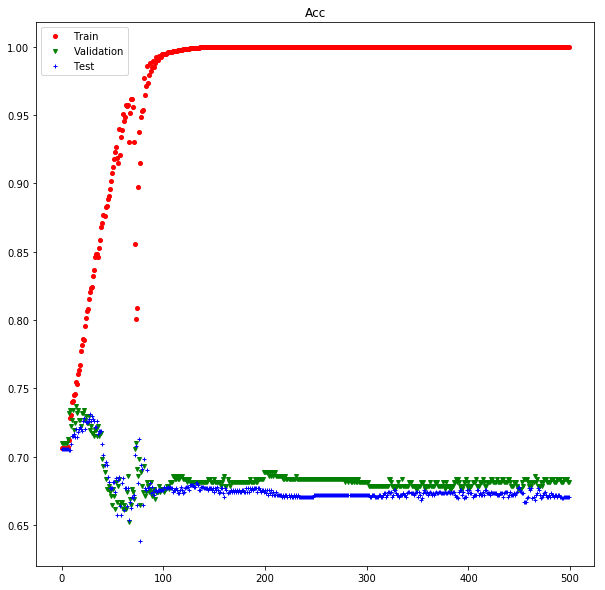

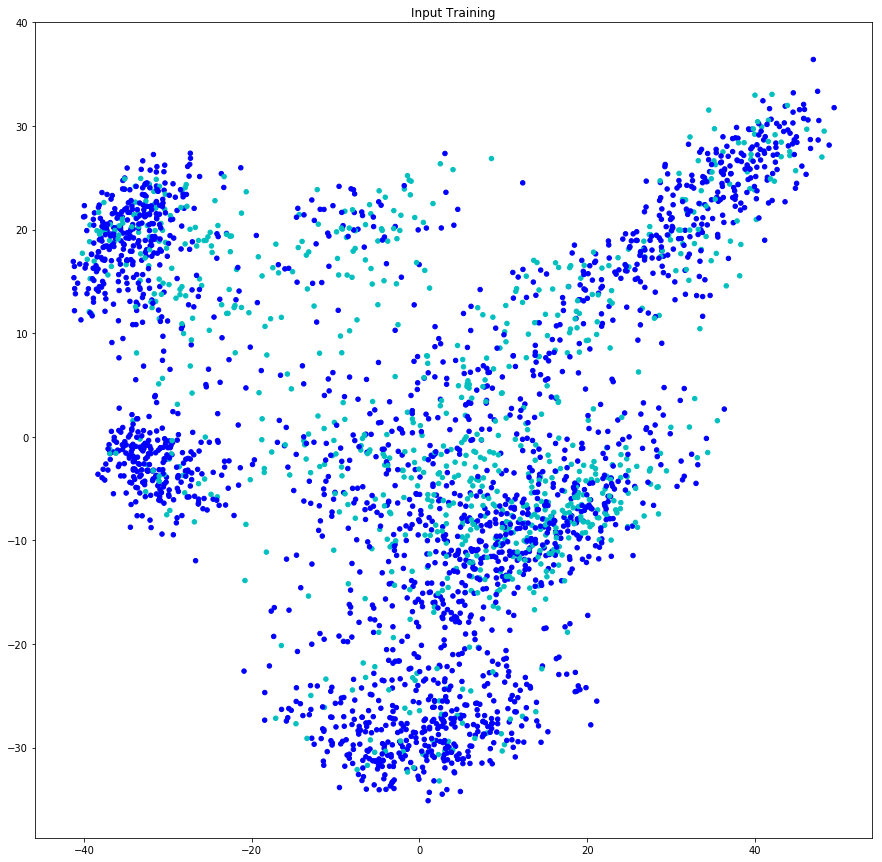

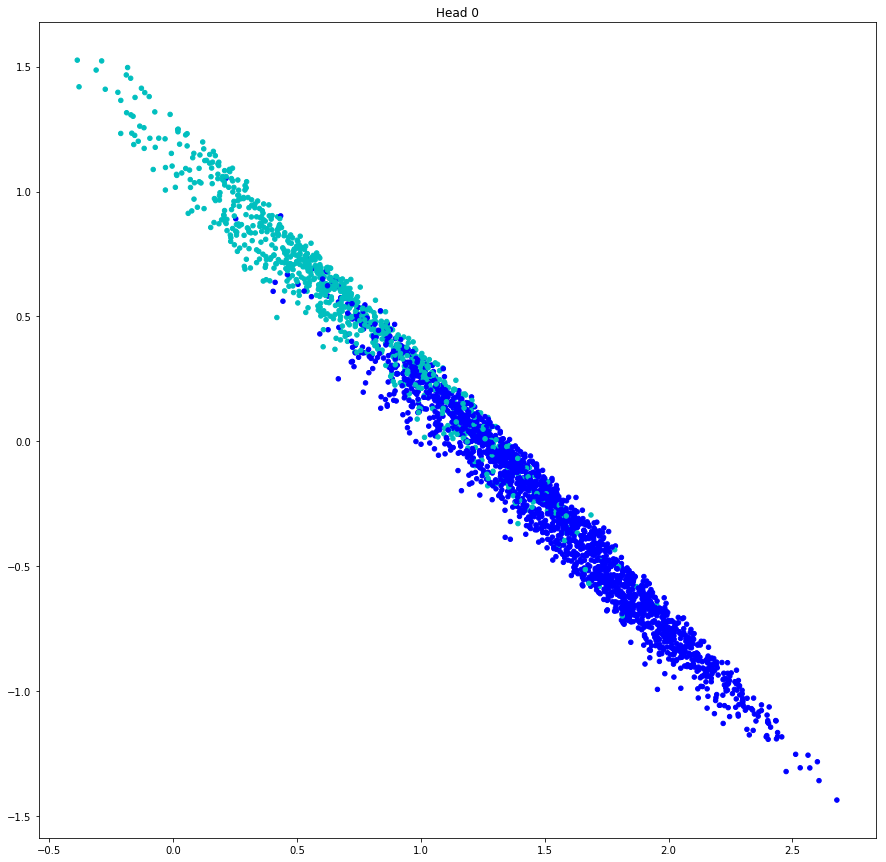

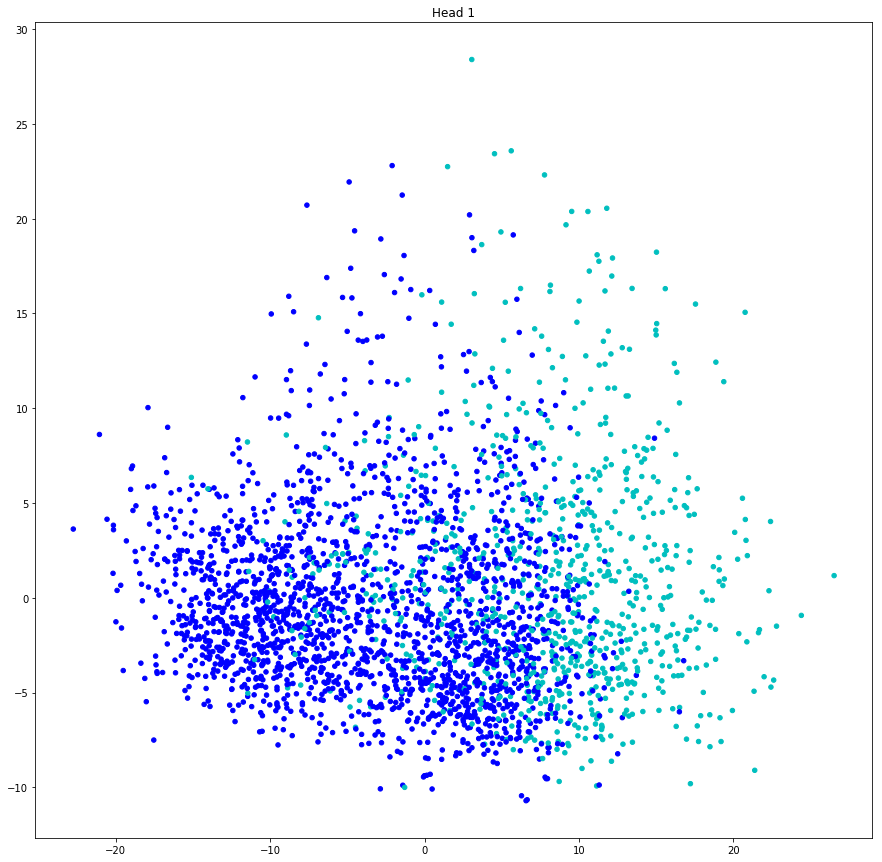

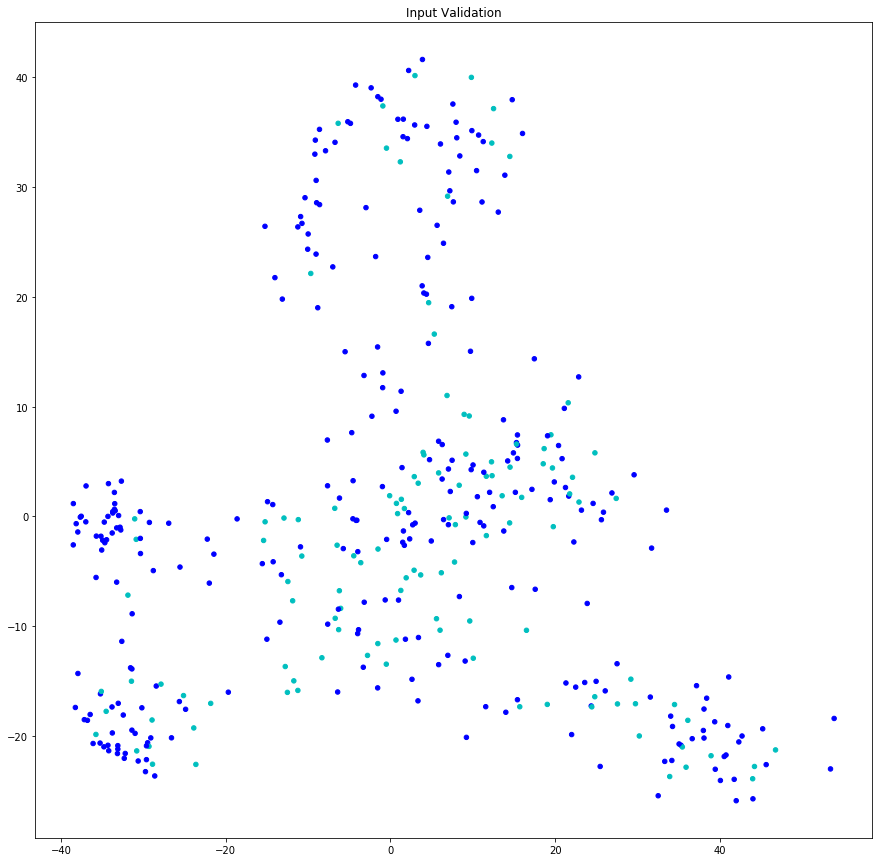

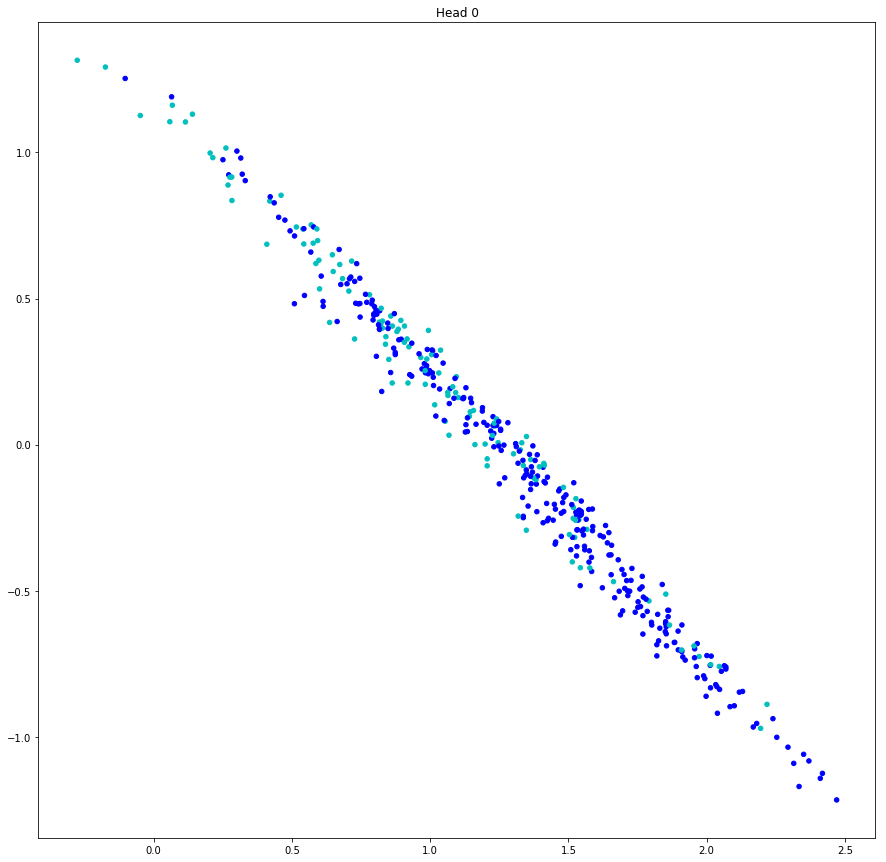

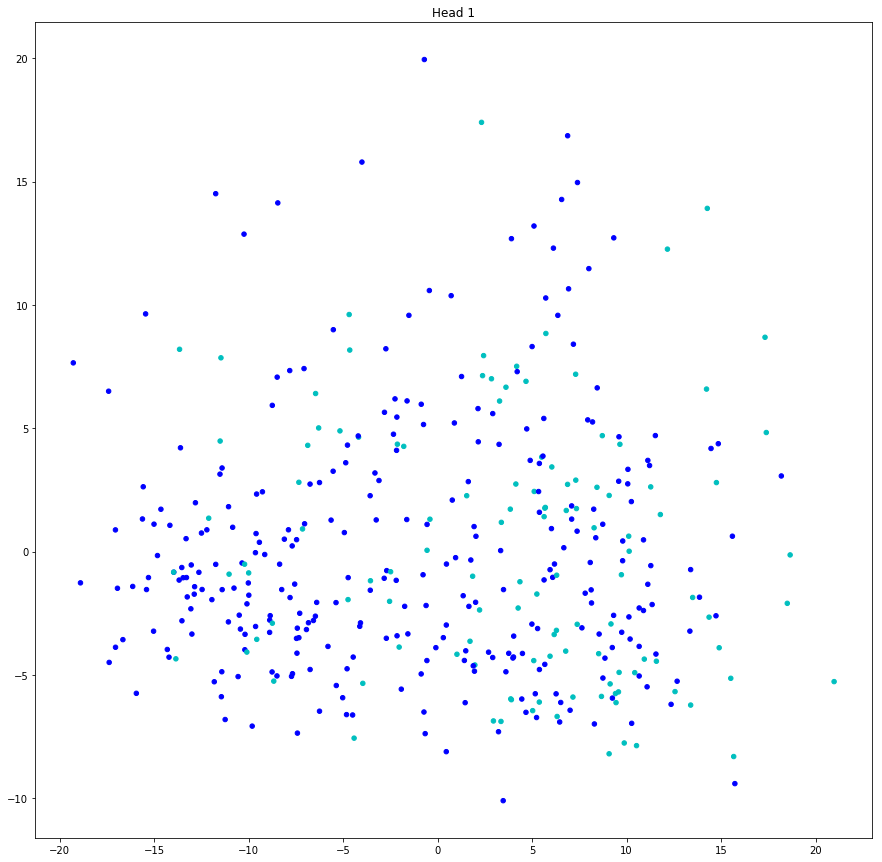

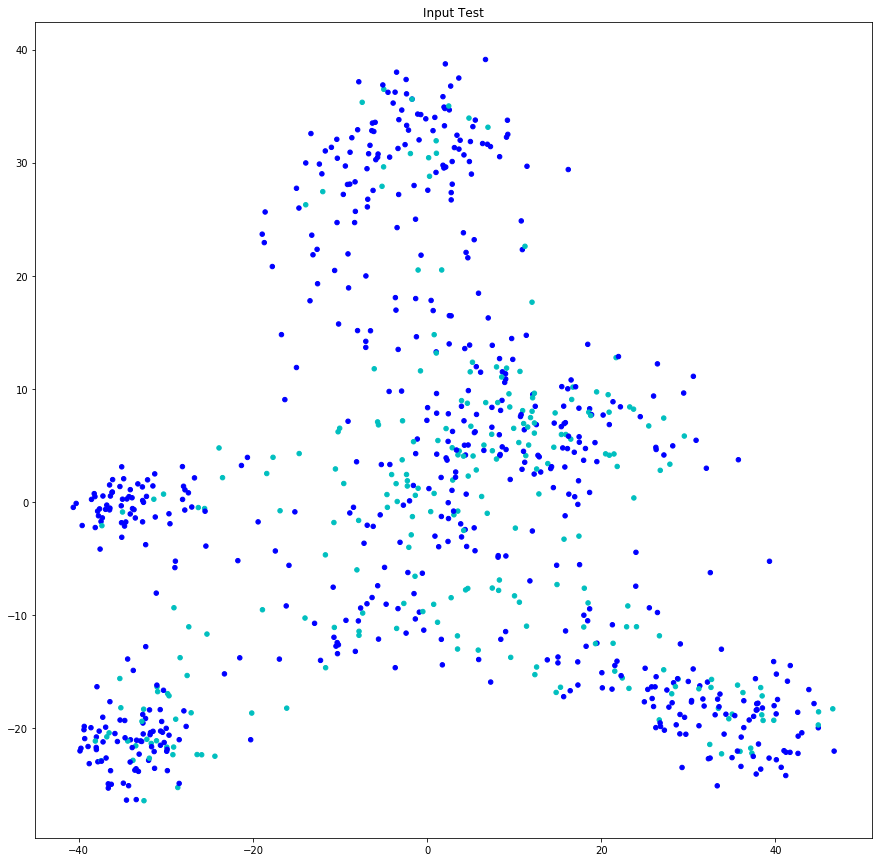

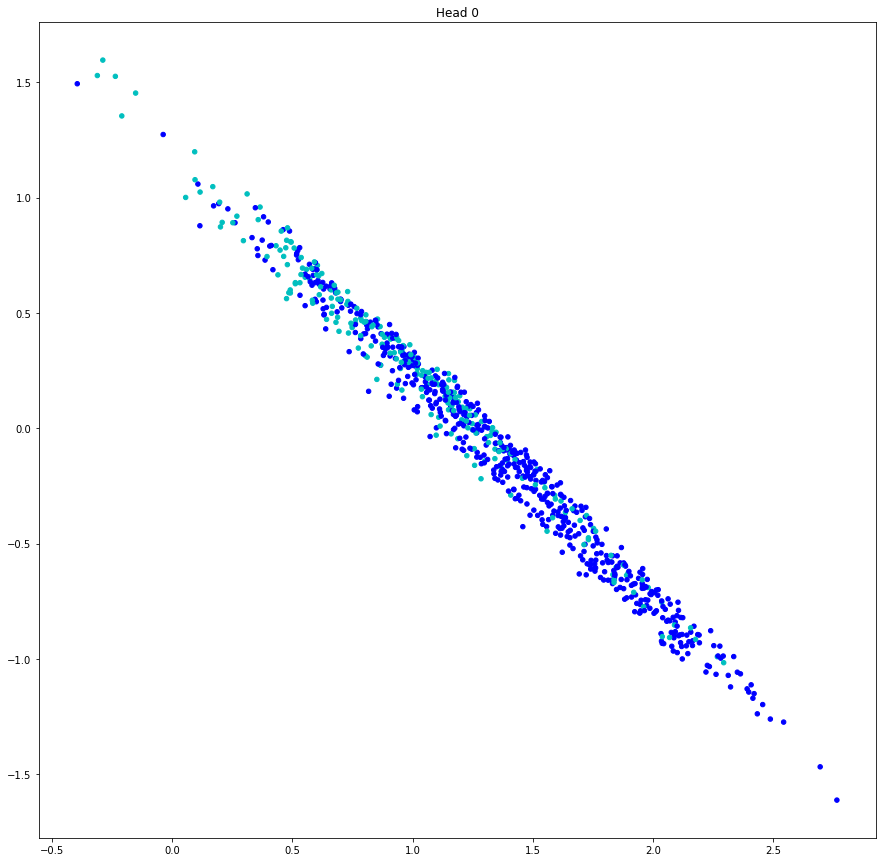

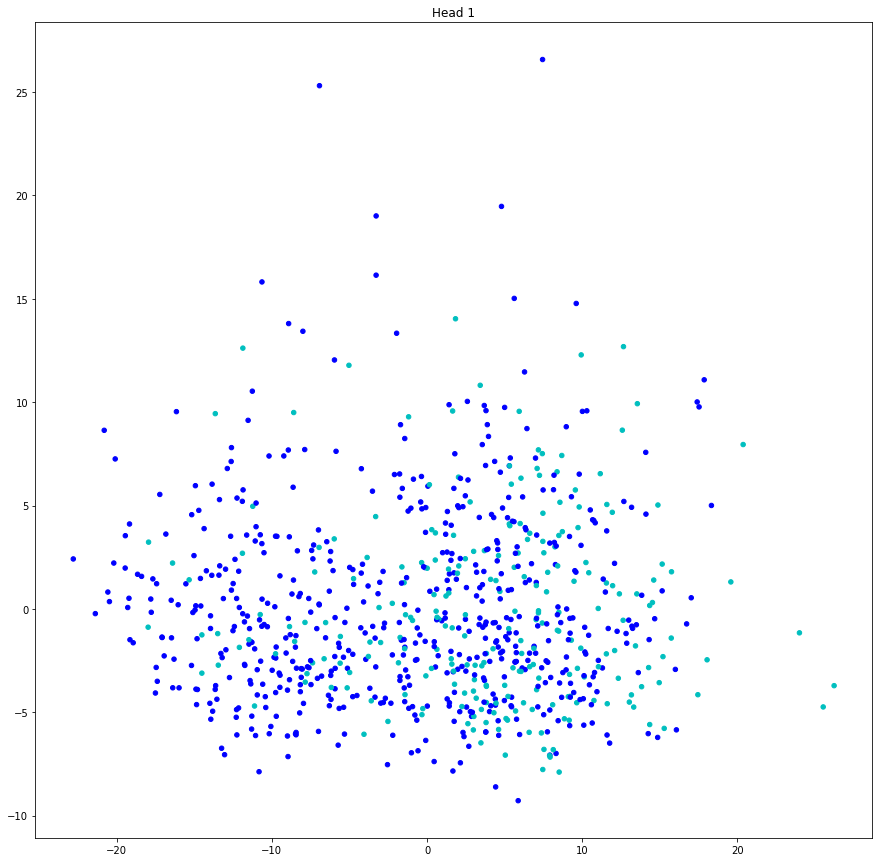

In [24]:
if num_data_types > 1:
  print('MultiviewAE with view similarity regularizers')
  model_names.append('MultiviewAE + view_sim')
  model = MultiviewAE(in_dims=in_dims, hidden_dims=hidden_dim, out_dim=num_cls, 
                      fuse_type=fuse_type, dense=dense, residual=residual, 
                      residual_layers='all', decoder_norm=decoder_norm, 
                      decoder_norm_dim=0, uniform_decoder_norm=uniform_decoder_norm, 
                      nonlinearity=nn.ReLU(), last_nonlinearity=True, bias=True).to(device)
  loss_weights = [1,1,1]
  other_loss_weights = [0]
  heads = [0,1,2]
  run_one_model(model, loss_weights, other_loss_weights, 
                loss_his_all, acc_his_all, metric_all, confusion_mat_all,
                heads=heads, multi_heads=True, return_results=False, 
                loss_fns=loss_fns, other_loss_fns=other_loss_fns, 
                lr=lr, weight_decay=weight_decay, batch_size=batch_size, 
                num_epochs=num_epochs, reduce_every=reduce_every, eval_every=eval_every, 
                print_every=print_every, x_train=x_train, y_train=y_train,
                x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test,
                show_results_in_notebook=show_results_in_notebook)

MultiviewAE with both feature interaction and view similarity regularizers
Epoch0 Train: loss:6.51e-01, 1.14e+00, -7.10e-01, 2.02e+00, acc=0.58
Epoch0 Test: loss:5.99e-01, 1.21e+00, -8.96e-01, 2.02e+00, acc=0.71
epoch 0, best_val_acc=0.71, train_acc=0.58
Epoch0 Test: loss:6.05e-01, 1.21e+00, -8.98e-01, 2.02e+00, acc=0.71
epoch 28, best_val_acc=0.71, train_acc=0.72
epoch 29, best_val_acc=0.72, train_acc=0.72
epoch 31, best_val_acc=0.72, train_acc=0.73
epoch 33, best_val_acc=0.72, train_acc=0.74
epoch 36, best_val_acc=0.72, train_acc=0.76
epoch 39, best_val_acc=0.73, train_acc=0.77
epoch 40, best_val_acc=0.73, train_acc=0.77
epoch 43, best_val_acc=0.73, train_acc=0.79
Epoch100 Train: loss:1.90e-01, 2.62e-01, -9.79e-01, 5.60e-02, acc=0.95
Epoch100 Test: loss:6.90e-01, 2.60e-01, -9.80e-01, 5.54e-02, acc=0.67
Epoch100 Test: loss:6.76e-01, 2.58e-01, -9.81e-01, 5.54e-02, acc=0.69
Epoch200 Train: loss:4.43e-02, 2.19e-01, -9.83e-01, 2.53e-02, acc=1.00
Epoch200 Test: loss:9.90e-01, 2.18e-01, -9.

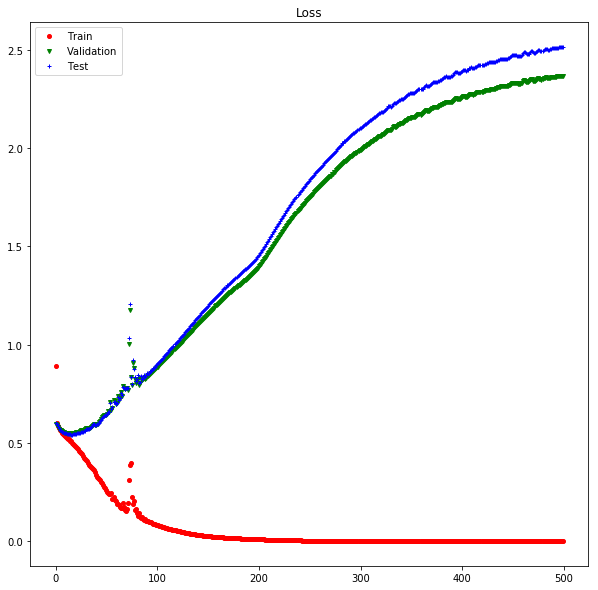

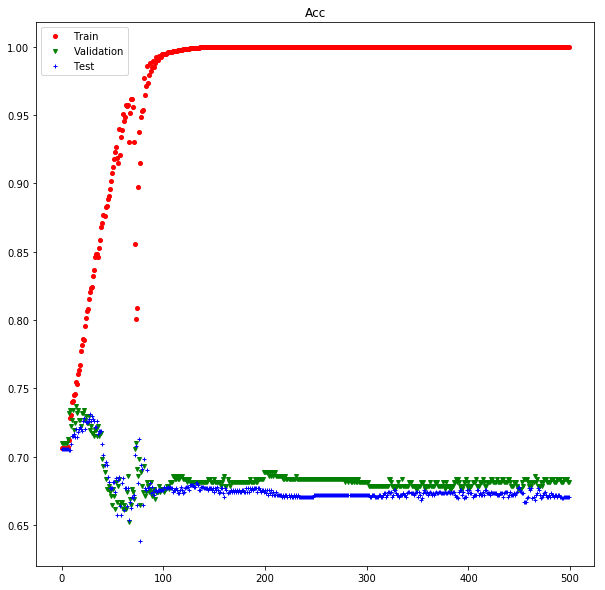

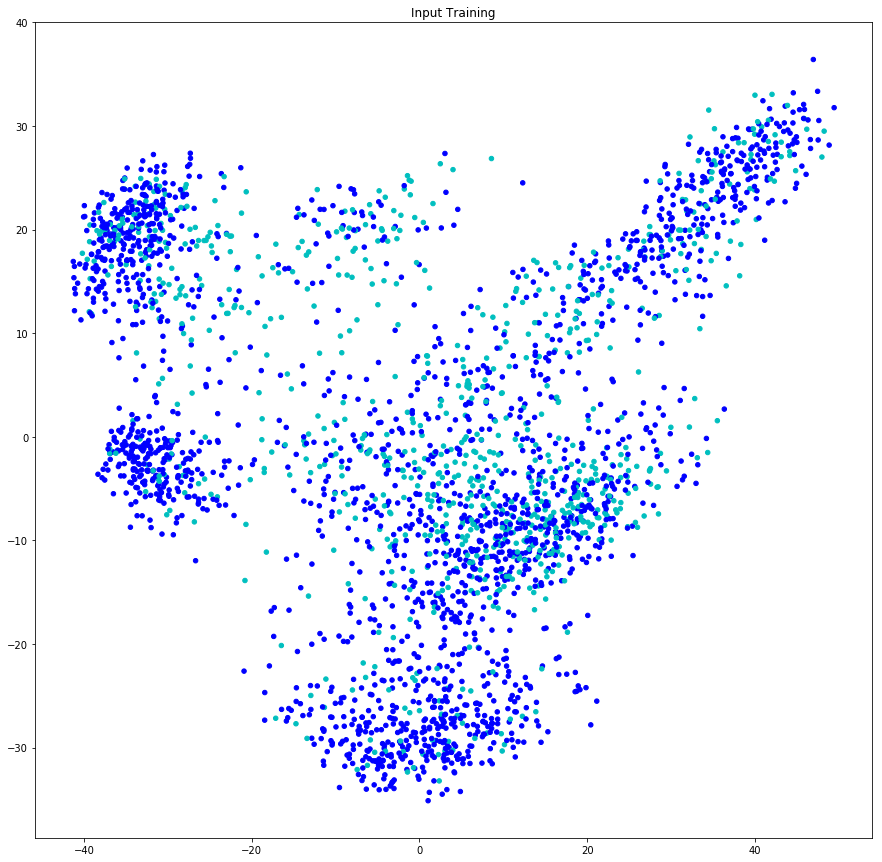

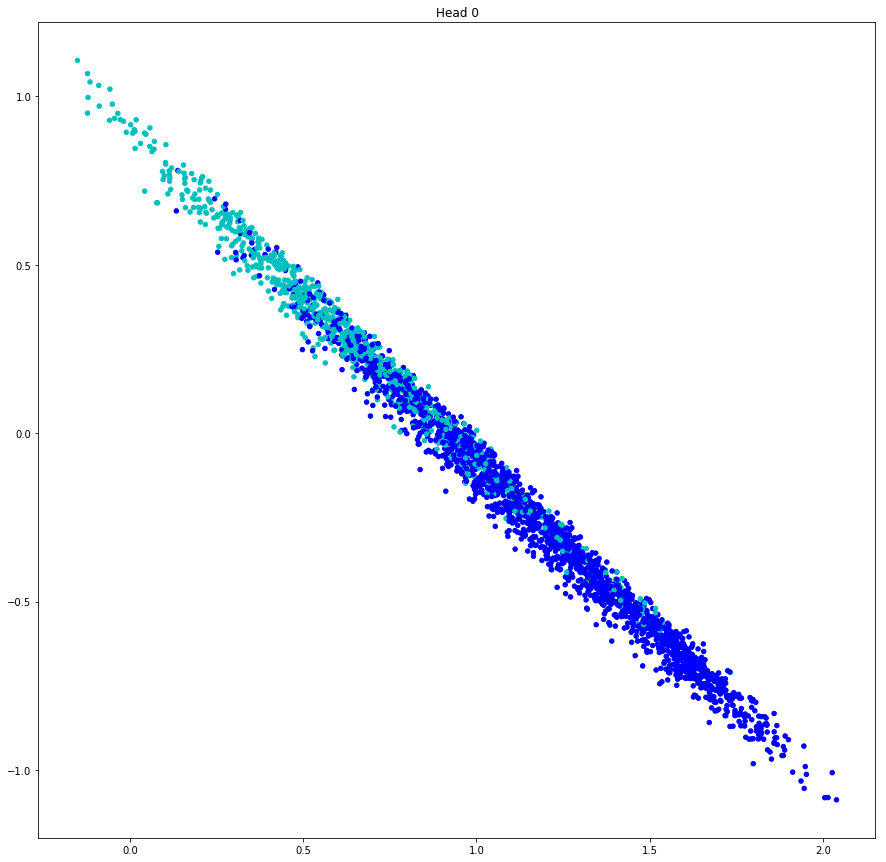

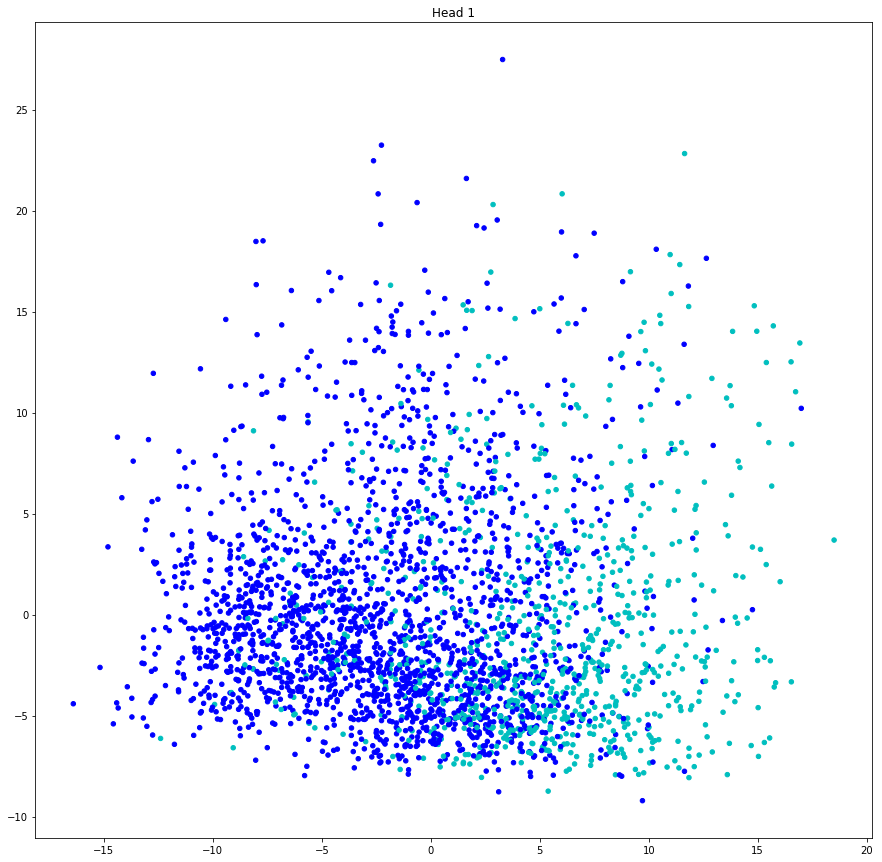

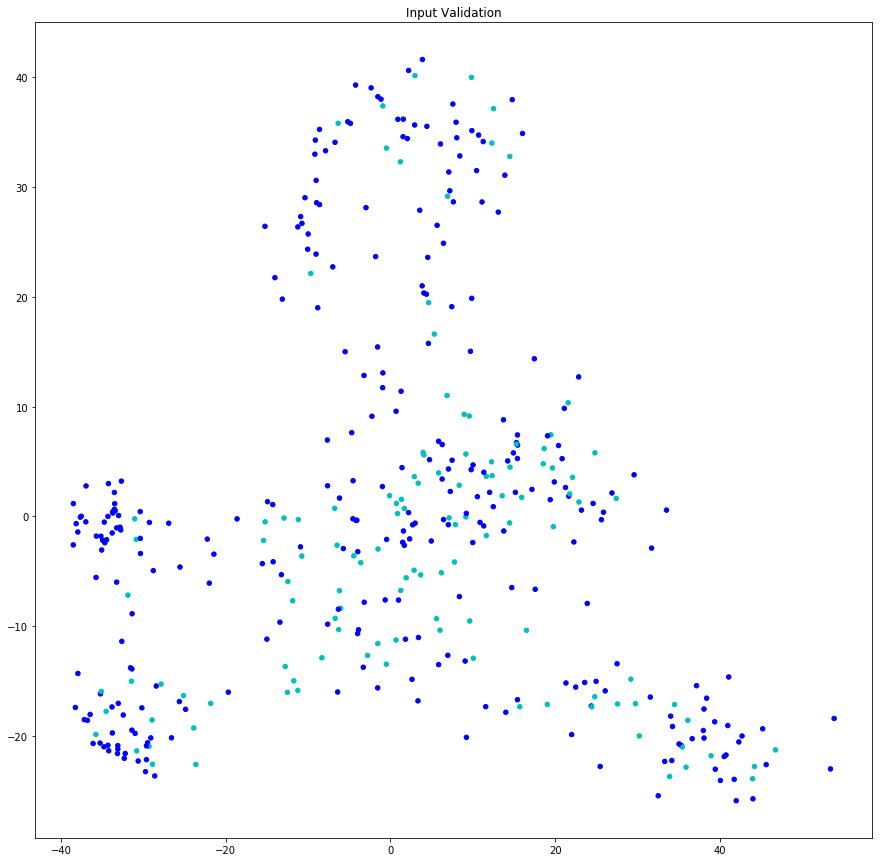

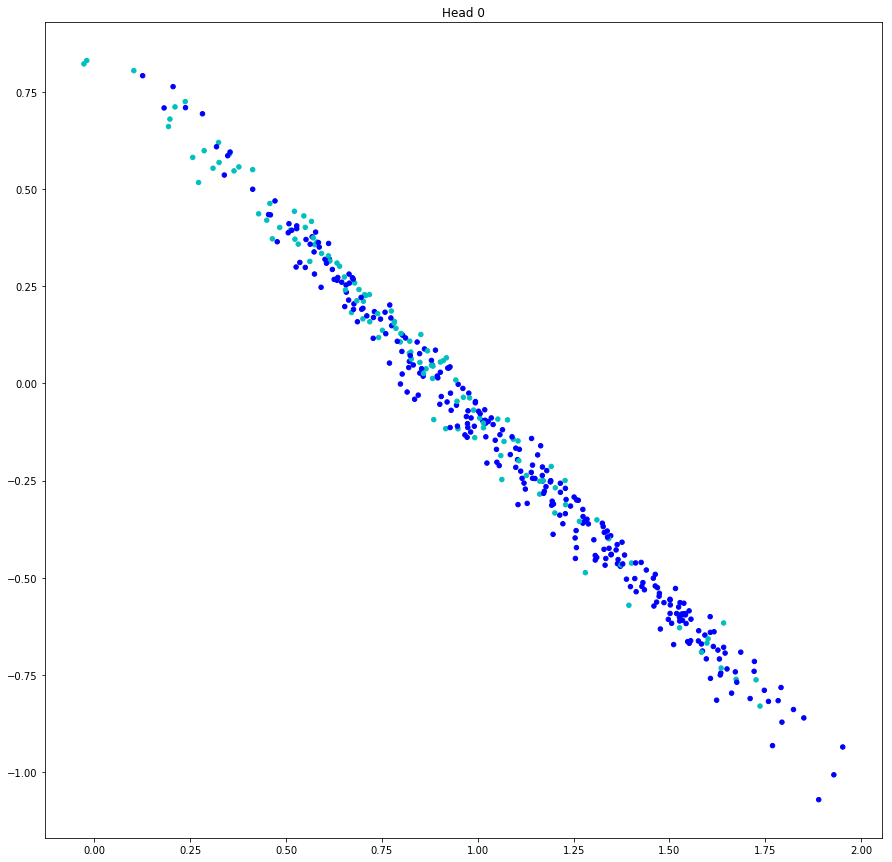

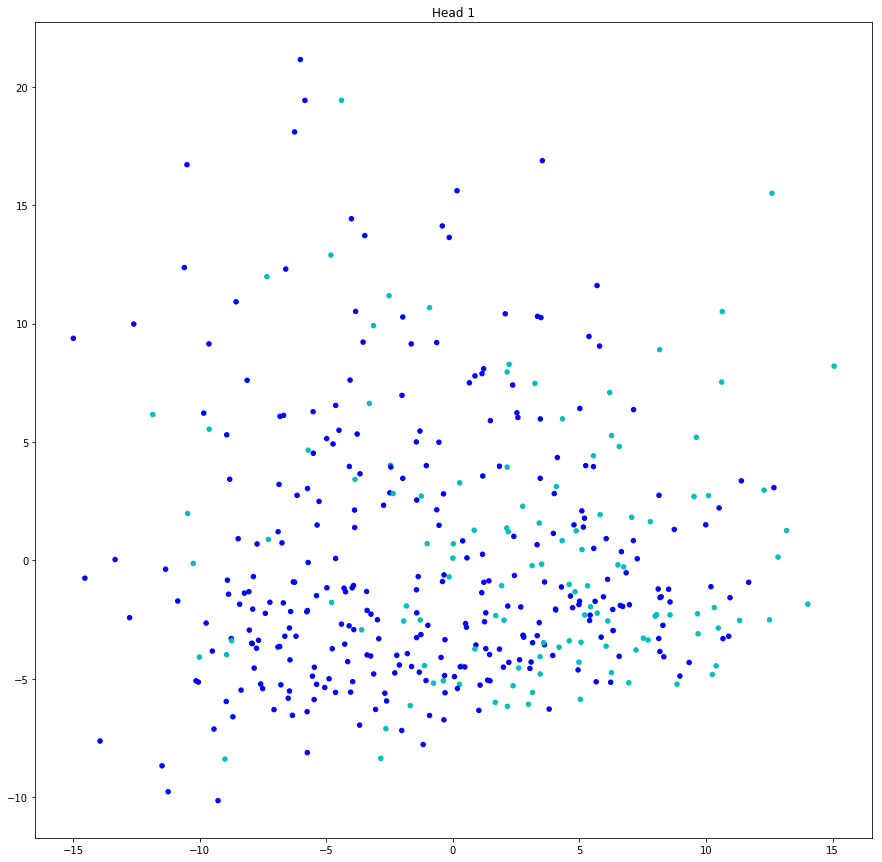

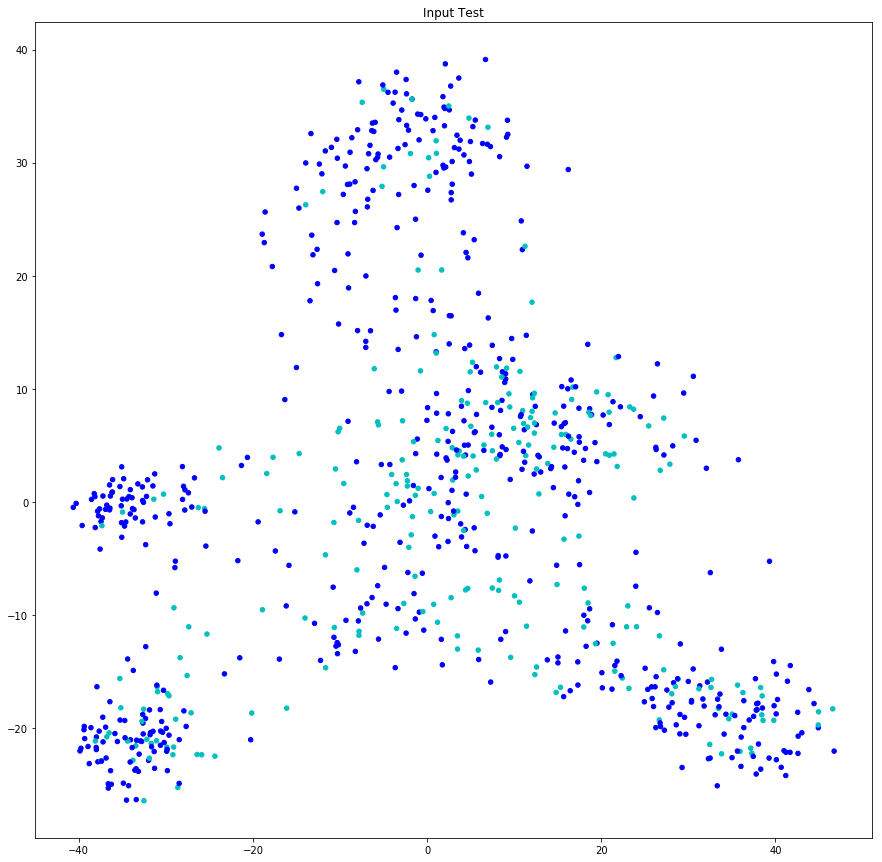

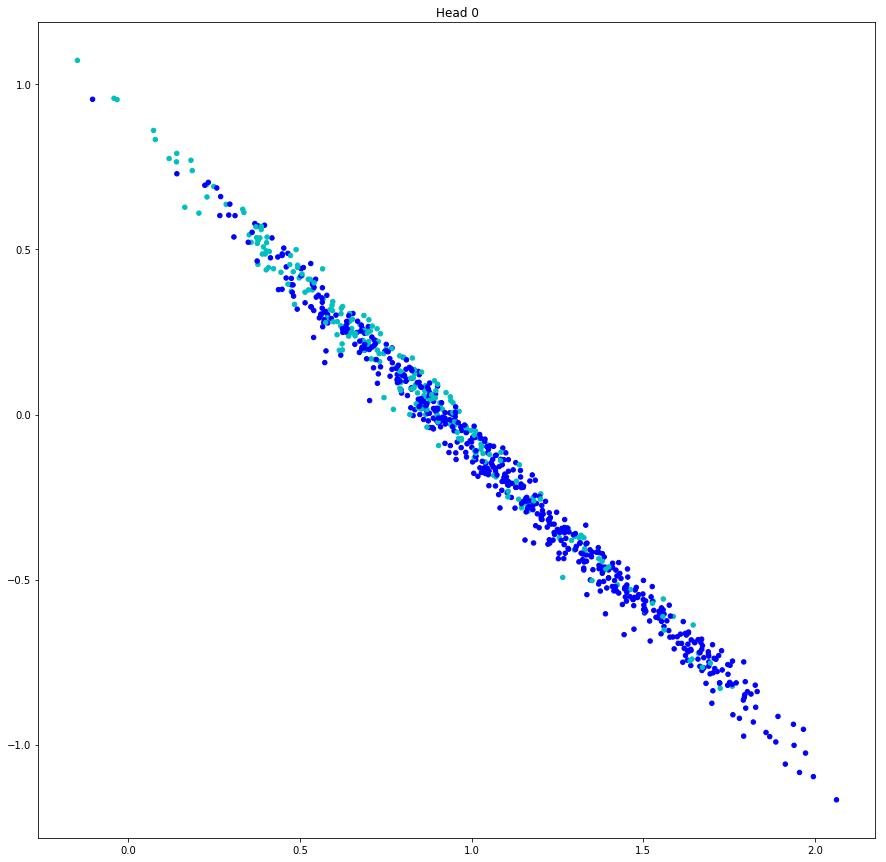

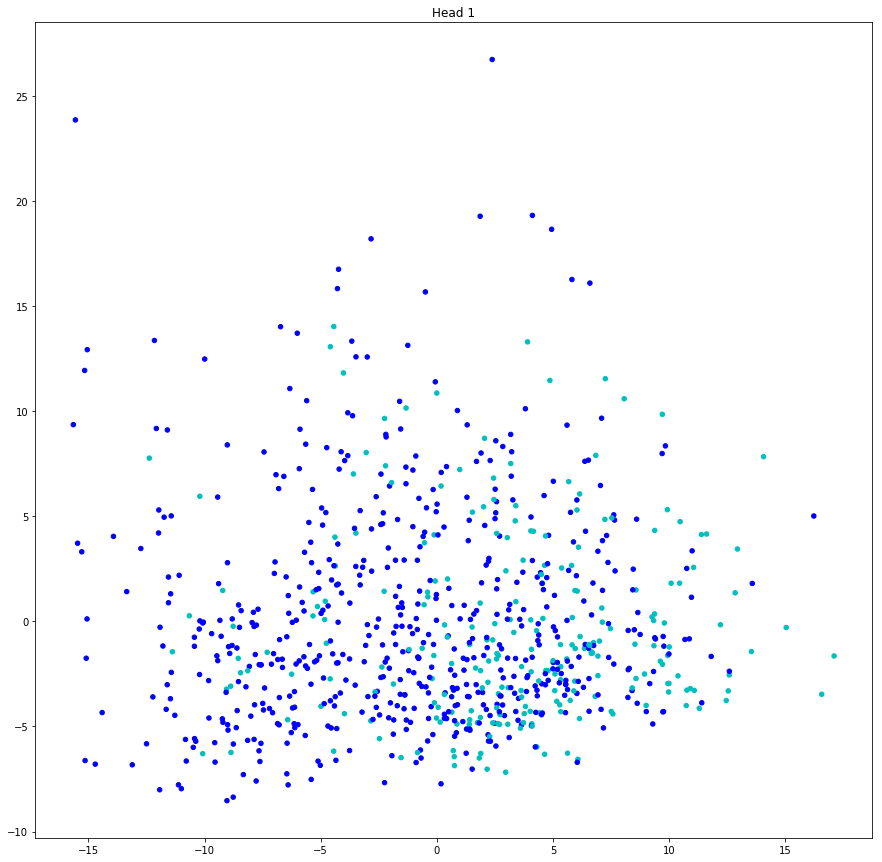

In [25]:
if num_data_types > 1:
  print('MultiviewAE with both feature interaction and view similarity regularizers')
  model_names.append('MultiviewAE + feat_int + view_sim')
  model = MultiviewAE(in_dims=in_dims, hidden_dims=hidden_dim, out_dim=num_cls, 
                      fuse_type=fuse_type, dense=dense, residual=residual, 
                      residual_layers='all', decoder_norm=decoder_norm, 
                      decoder_norm_dim=0, uniform_decoder_norm=uniform_decoder_norm, 
                      nonlinearity=nn.ReLU(), last_nonlinearity=True, bias=True).to(device)
  loss_weights = [1,1,1]
  other_loss_weights = [1]
  heads = [0,1,2]
  run_one_model(model, loss_weights, other_loss_weights,
                loss_his_all, acc_his_all, metric_all, confusion_mat_all,
                heads=heads, multi_heads=True, return_results=False, 
                loss_fns=loss_fns, other_loss_fns=other_loss_fns, 
                lr=lr, weight_decay=weight_decay, batch_size=batch_size, 
                num_epochs=num_epochs, reduce_every=reduce_every, eval_every=eval_every, 
                print_every=print_every, x_train=x_train, y_train=y_train,
                x_val=x_val, y_val=y_val, x_test=x_test, y_test=y_test,
                show_results_in_notebook=show_results_in_notebook)

In [26]:
with open(f'{result_folder}/{res_file}', 'wb') as f:
  print(f'Write result to file {result_folder}/{res_file}')
  pickle.dump({'loss_his_all': loss_his_all,
               'acc_his_all': acc_his_all,
               'metric_all': metric_all,
               'confusion_mat_all': confusion_mat_all,
               'model_names': model_names,
               'split_names': split_names,
               'metric_names': metric_names
              }, f)

Write result to file results/PFI_instance-shuffle_age_at_initial_pathologic_diagnosis-ajcc_pathologic_tumor_stage-gender_gene-methy-mirna-rppa_all_100-0_0.7-0.1-0.2_10sets_4_100-100_nn.pkl
